In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from retrieve_preprocessed_dataset import *

1) retrieve_dataset.py to download epigenomic_dataset and FANTOM

2) retrieve_sequence.ipynb to download Genome sequence

3) labels_threshold.py: analysis of labels and different solutions for binarizing them

3) pre_processing.py: NaN imputation, normalization

4) correlations.py: remove features correlated with output and features related to each other

5) feature_selection: use of Boruta algorithm to determine relevant features

6) PCA

### Label

In [2]:
epigenomes, labels, sequences = retrieve_preprocessed_dataset()

### Features distribution

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis = 1).flatten())[:n]

Top 5 different features from promoters.


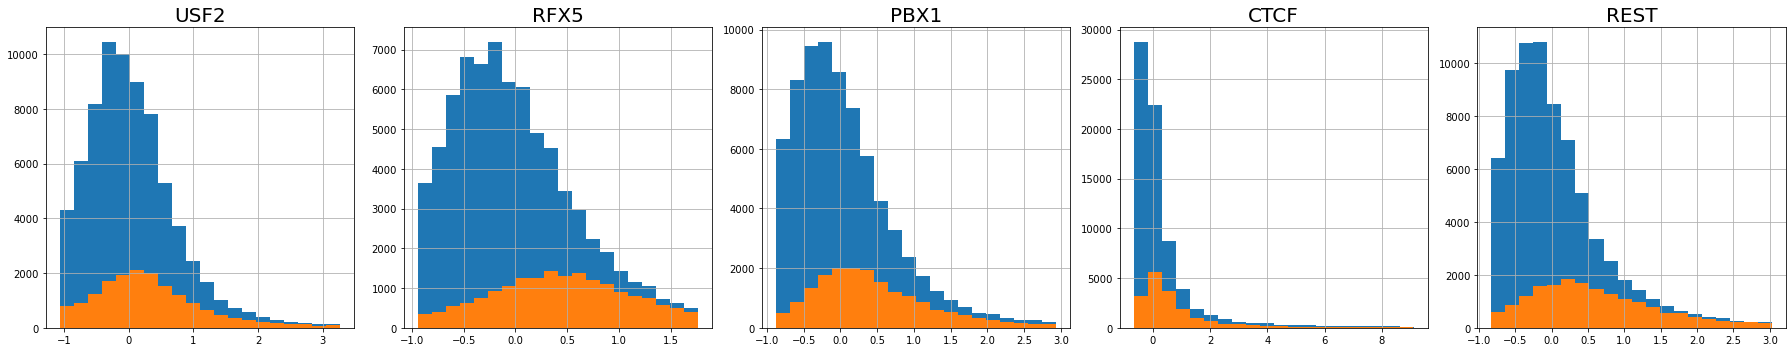

Top 5 different features from enhancers.


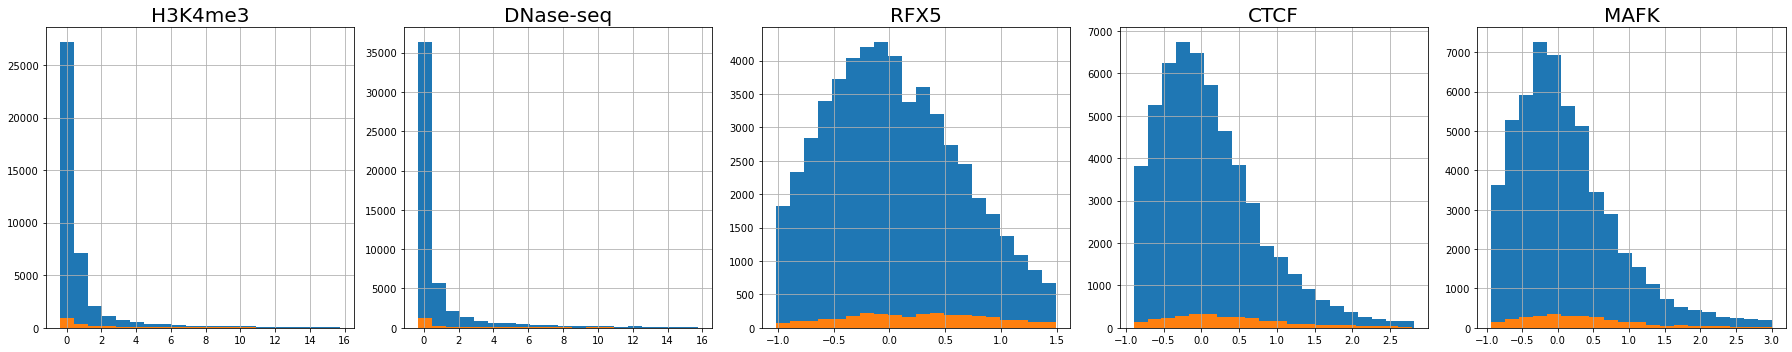

In [5]:
top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = labels[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column, fontsize=20)
    fig.tight_layout()
    plt.savefig(f'.\\img\\features_distribution_{region}.jpg')
    plt.show()


#### Retrieve sequence

In [6]:
from ucsc_genomes_downloader import Genome
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|                                                      | 0/25 [00:00<…

In [7]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

## MODEL

In [10]:
from typing import Dict, List, Tuple, Optional
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from extra_keras_metrics import get_complete_binary_metrics
from tensorflow import keras

In [11]:
# def build_functional_perceptron(input_shape: int)-> Model:

#     input_epigenomic_data = Input(shape = (input_shape,), name = "epigenomic_data")
#     output = Dense(1, activation = "sigmoid")(input_epigenomic_data)

#     perceptron = Model(
#         inputs = input_epigenomic_data,
#         outputs = output,
#         name = "perc"
#     ) 

#     perceptron.compile(
#         optimizer = "nadam",
#         loss = "binary_crossentropy",
#         metrics = get_complete_binary_metrics()
#     )
    
#     return perceptron

In [46]:
def build_perceptron(input_shape: int)->Tuple[Model, Layer, Layer]:

    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    perceptron = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="perc"
    )

    perceptron.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return perceptron, input_epigenomic_data, output_ffnn

In [18]:
# # SEQUENTIAL

# def build_ffnn(input_shape:int) -> Tuple[Model, Layer, Layer]:
    
#     input_epigenomic_data = Input(shape = (input_shape,), name = "epigenomic_data")
#     output = Dense(1, activation="sigmoid")
    
#     ffnn = Sequential([
#         input_epigenomic_data,
#         Dense(16, activation = 'relu'),
#         Dense(4, activation="relu"),
#         output
#     ])
    
#     last_hidden = Dense(4, activation="relu")
#     model._name = 'FFNN'
    
#     ffnn.compile(
#         optimizer = "SGD", 
#         loss = "binary_crossentropy", 
#         metrics = get_complete_binary_metrics())
    
#     return ffnn, input_epigenomic_data, last_hidden

In [11]:
def build_functional_ffnn(input_shape:int) -> Tuple[Model, Layer, Layer]:
    
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(16, activation="relu")(input_epigenomic_data)

    for _ in range(1):
        hidden = Dense(4, activation="relu")(hidden)
        hidden = Dense(2, activation="relu")(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(hidden)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="FFNN"
    )

    ffnn.compile(
        optimizer = "nadam", 
        loss = "binary_crossentropy", 
        metrics = get_complete_binary_metrics())
    
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [13]:
m,t,t = build_functional_ffnn(44)
m.summary()

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 epigenomic_data (InputLayer  [(None, 44)]             0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 16)                720       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
 dense_6 (Dense)             (None, 2)                 10        
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
________________________________________________________________

In [42]:
def build_functional_cnn(window_size: int)->Tuple[Model, Layer, Layer]:

    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="relu")(input_sequence_data)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Conv1D(128, kernel_size=3, activation="relu")(hidden)
    hidden = GlobalAveragePooling1D()(hidden)
    hidden = Dropout(rate=0.5)(hidden)
    
    last_hidden_cnn =  Dense(10, activation = 'relu')(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)
    
    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="CNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

In [8]:
# def build_sequential_cnn(window_size: int):
   
#     input_sequence_data = Input(shape=(window_size,4 ), name="sequence_data")
#     output =  Dense(1, activation="sigmoid")
    
#     model = Sequential([
#         input_sequence_data,
#         Conv1D(64, kernel_size=5, activation="relu"),
#         MaxPool1D(pool_size=2),
#         Conv1D(128, kernel_size=3, activation="relu"),
#         GlobalAveragePooling1D(),
#         Dropout(rate=0.5),
#         Dense(10, activation = 'relu'),
#         Dropout(rate=0.5),
#         output
#     ])
    
#     model._name = 'CNN'


#     model.compile(
#         optimizer="nadam",
#         loss="binary_crossentropy",
#         metrics=get_complete_binary_metrics()
#     )
#     return model

In [83]:
def build_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):

    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_functional_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_functional_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

## Training

#### get sequences

In [92]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(X: np.ndarray, y: np.ndarray, batch_size: int = 1024) -> MixedSequence:

    return MixedSequence(
        
        x = {"epigenomic_data": VectorSequence(X, batch_size)},
        
        y = VectorSequence(y, batch_size)
    )

from keras_bed_sequence import BedSequence


def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024) -> MixedSequence:

    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024) -> MixedSequence:

    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [93]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(
    model: Model,
    model_name: str,
    task: str,
    train_sequence,
    test_sequence,
    holdout_number: int) -> Tuple[pd.DataFrame, pd.DataFrame]:

    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data = test_sequence,
        epochs = 10,
        verbose = False,
        callbacks = [EarlyStopping("loss", min_delta = 0.001, patience = 2, mode = "min"),]).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose = False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose = False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

#### Holdout

In [96]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# aumentare numero di splits (10)
number_of_splits = 15

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2
)

#### Training perceptron, ffnn, cnn

In [97]:
all_binary_classification_performance = []

training_histories = {}
window_size = 256

for region, X in epigenomes.items():

    y = labels[region]
    training_histories[region] = []

    number_of_features = X.shape[1]
    bed = to_bed(X)
    
    for holdout_index, (train_indices, test_indices) in enumerate(holdouts_generator.split(X, y)):
        
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices].values , X.iloc[test_indices].values 
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
          
        perceptron,_ ,_ = build_perceptron(number_of_features)
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_functional_ffnn(number_of_features)
        cnn, input_sequence_data, last_hidden_cnn = build_functional_cnn(window_size)
        mmnn1 = build_mmnn(number_of_features, window_size)
        
        mmnn2 = build_binary_classification_mmnn(
            input_sequence_data=input_sequence_data,
            input_epigenomic_data=input_epigenomic_data,
            last_hidden_ffnn=last_hidden_ffnn,
            last_hidden_cnn=last_hidden_cnn
        )

        train_ffnn_sequence = get_ffnn_sequence(train_X, train_y)
        test_ffnn_sequence = get_ffnn_sequence(test_X, test_y)
        train_cnn_sequence = get_cnn_sequence(genome, train_bed, train_y) 
        test_cnn_sequence = get_cnn_sequence(genome, test_bed, test_y)
        train_mmnn_sequence = get_mmnn_sequence(genome, train_bed, train_X, train_y)
        test_mmnn_sequence =  get_mmnn_sequence(genome, test_bed, test_X, test_y)
        
        for model, train_sequence, test_sequence in [
            (perceptron,  train_ffnn_sequence, test_ffnn_sequence),
            (ffnn, train_ffnn_sequence, test_ffnn_sequence),
            (cnn,  train_cnn_sequence, test_cnn_sequence),
            (mmnn1, train_mmnn_sequence, test_mmnn_sequence),
            (mmnn2, train_mmnn_sequence, test_mmnn_sequence)
        ]:
            
            print('task on ' + str(region) + " - " + str(holdout_index + 1) + " holdout - model: " + model.name)
        
            history, performance = train_model(
                    model,
                    model.name,
                    task = region,
                    train_sequence = train_sequence,
                    test_sequence = test_sequence,
                    holdout_number = holdout_index
                )

            all_binary_classification_performance.append(performance)
    print("-"*80)
        
all_binary_classification_performance = pd.concat(all_binary_classification_performance)   

task on promoters - 1 holdout - model: perc
task on promoters - 1 holdout - model: FFNN
task on promoters - 1 holdout - model: CNN
task on promoters - 1 holdout - model: MMNN
task on promoters - 1 holdout - model: BoostedMMNN
task on promoters - 2 holdout - model: perc
task on promoters - 2 holdout - model: FFNN
task on promoters - 2 holdout - model: CNN
task on promoters - 2 holdout - model: MMNN
task on promoters - 2 holdout - model: BoostedMMNN
task on promoters - 3 holdout - model: perc
task on promoters - 3 holdout - model: FFNN
task on promoters - 3 holdout - model: CNN
task on promoters - 3 holdout - model: MMNN
task on promoters - 3 holdout - model: BoostedMMNN
task on promoters - 4 holdout - model: perc
task on promoters - 4 holdout - model: FFNN
task on promoters - 4 holdout - model: CNN
task on promoters - 4 holdout - model: MMNN
task on promoters - 4 holdout - model: BoostedMMNN
task on promoters - 5 holdout - model: perc
task on promoters - 5 holdout - model: FFNN
task on 

In [98]:
all_binary_classification_performance.to_csv('./performance/all_performance_perc_ffnn_cnn.csv')

In [99]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,holdout_number
0,0.448972,0.813989,0.483406,0.550202,0.816916,0.511628,0.514646,0.691061,0.898715,0.516594,...,0.691061,0.515724,0.421798,4.772747,0.574814,2.236881,train,perc,promoters,0
1,0.451012,0.815488,0.498528,0.553076,0.817217,0.513773,0.524387,0.697632,0.896736,0.501472,...,0.697632,0.525094,0.427700,4.827702,0.559219,2.307228,test,perc,promoters,0
0,0.522401,0.823488,0.388688,0.604869,0.814117,0.536537,0.473260,0.661806,0.934924,0.611312,...,0.661806,0.484876,0.461341,5.972862,0.653863,1.956884,train,FFNN,promoters,0
1,0.522507,0.823998,0.400638,0.603474,0.818038,0.538306,0.481569,0.666579,0.932520,0.599362,...,0.666579,0.491706,0.462023,5.937124,0.642734,1.999210,test,FFNN,promoters,0
0,0.442180,0.795993,0.000000,0.000000,0.744770,0.363398,0.000000,0.500000,1.000000,1.000000,...,0.500000,0.000000,-0.204007,0.000000,1.000000,1.000000,train,CNN,promoters,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.214206,0.943035,0.000000,0.000000,0.598153,0.104728,0.000000,0.500000,1.000000,1.000000,...,0.500000,0.000000,-0.056965,0.000000,1.000000,1.000000,test,CNN,enhancers,14
0,0.184139,0.943766,0.065579,0.551020,0.769030,0.259686,0.117209,0.531177,0.996775,0.934421,...,0.531177,0.190094,0.497466,20.331558,0.937444,1.133001,train,MMNN,enhancers,14
1,0.185055,0.943668,0.062413,0.548781,0.768206,0.254401,0.112080,0.529657,0.996900,0.937587,...,0.529657,0.185071,0.495023,20.133549,0.940502,1.126107,test,MMNN,enhancers,14
0,0.186379,0.943075,0.000000,0.000000,0.770763,0.242150,0.000000,0.500000,1.000000,1.000000,...,0.500000,0.000000,-0.056925,0.000000,1.000000,1.000000,train,BoostedMMNN,enhancers,14


Rendering barplots:   0%|                                                                       | 0/27 [00:00<…

((<Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure size 2000x840 with 2 Axes>,
  <Figure si

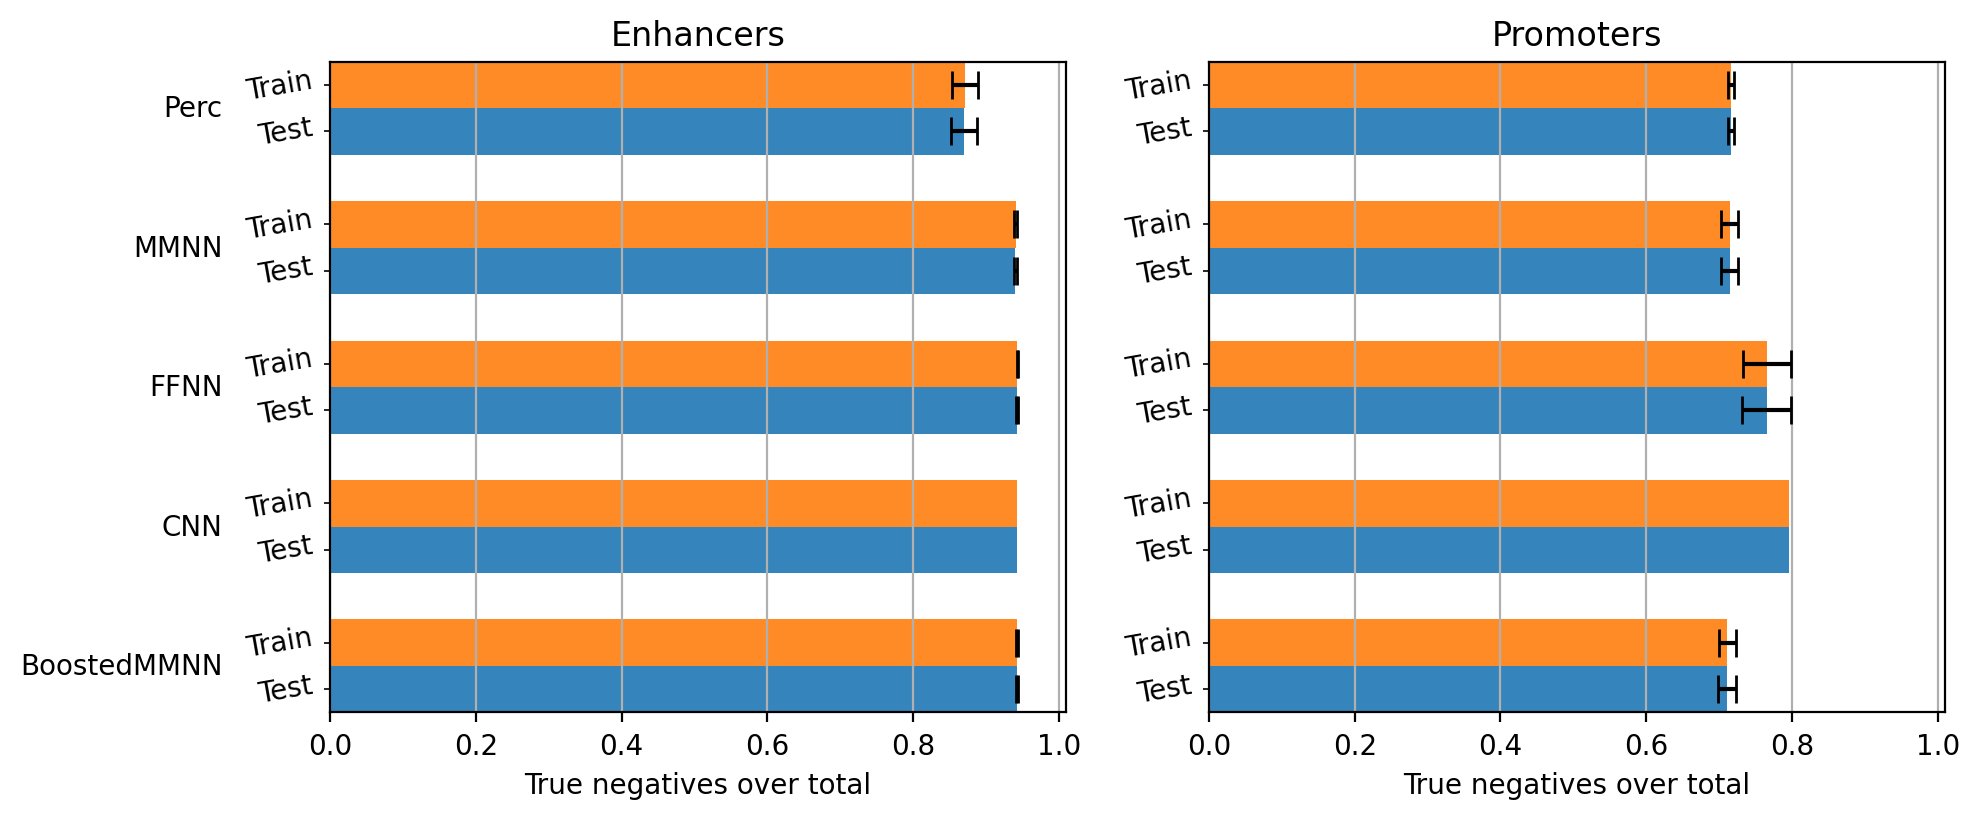

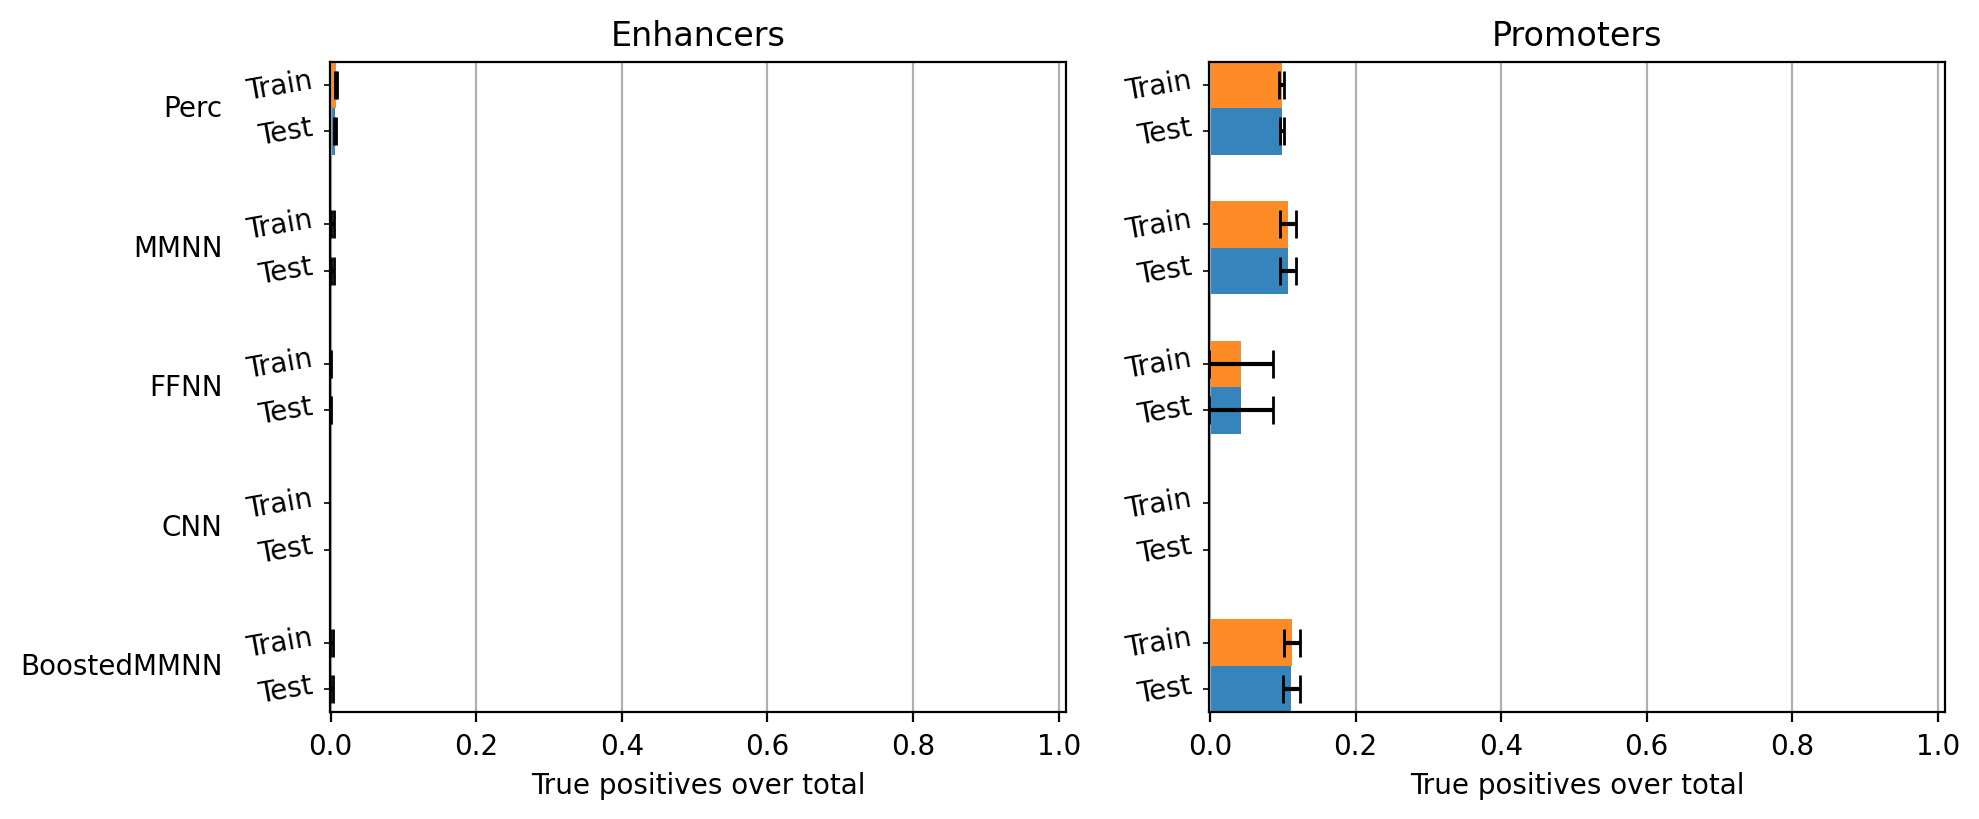

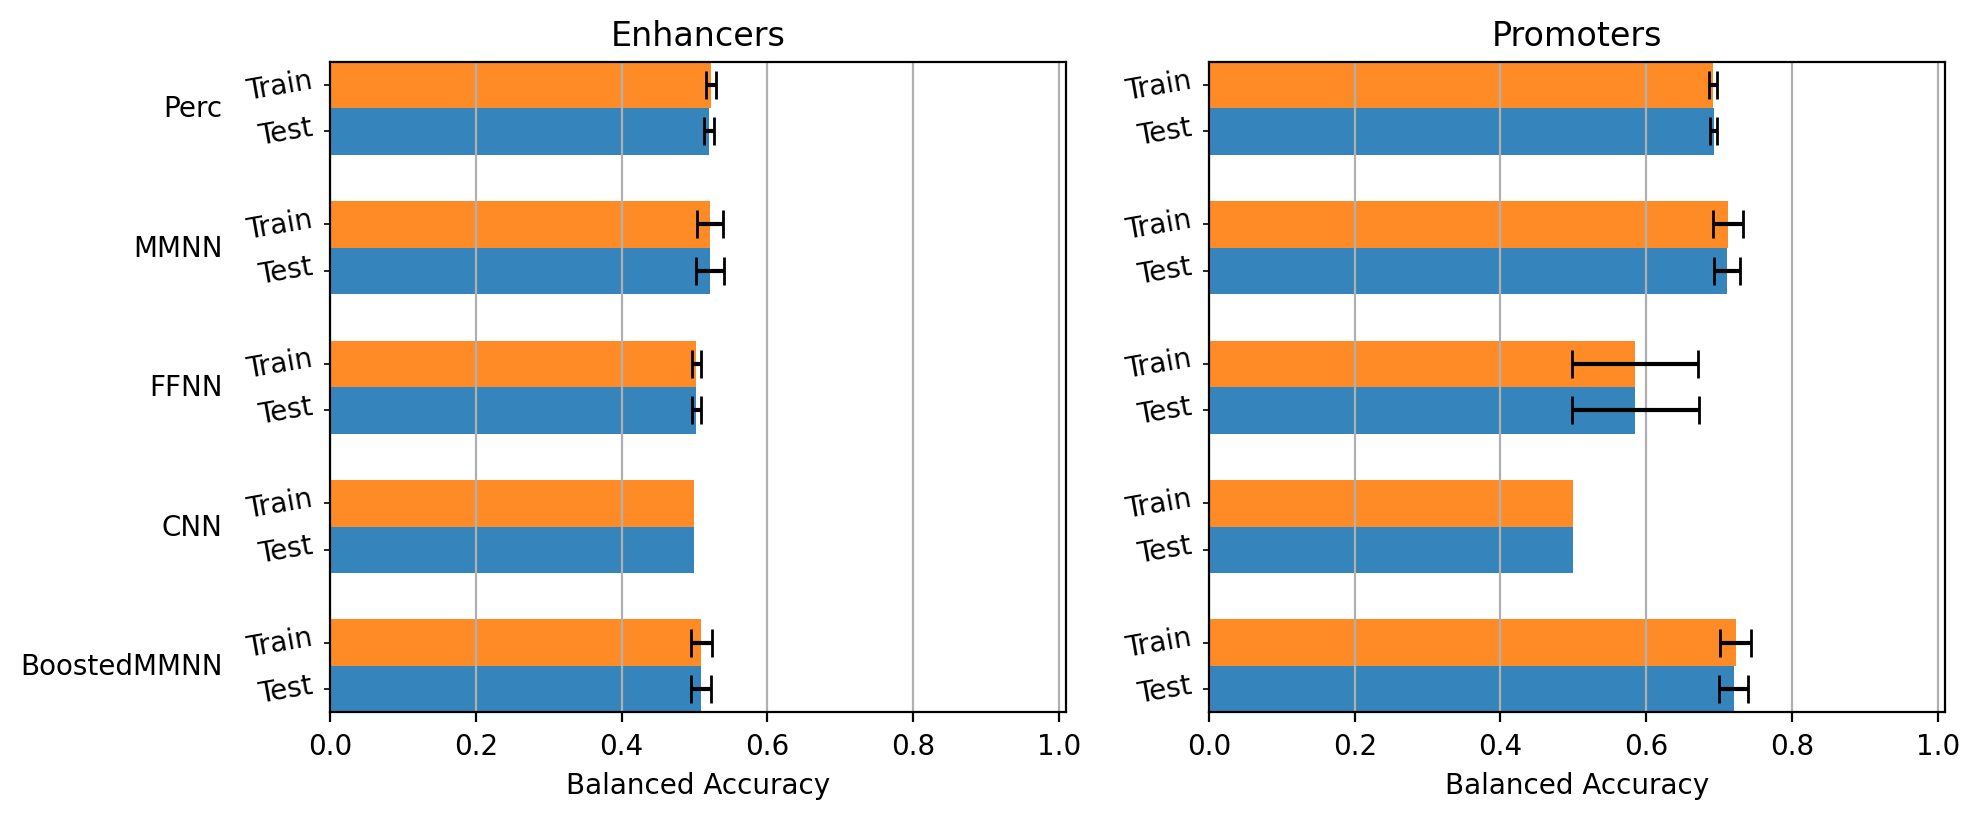

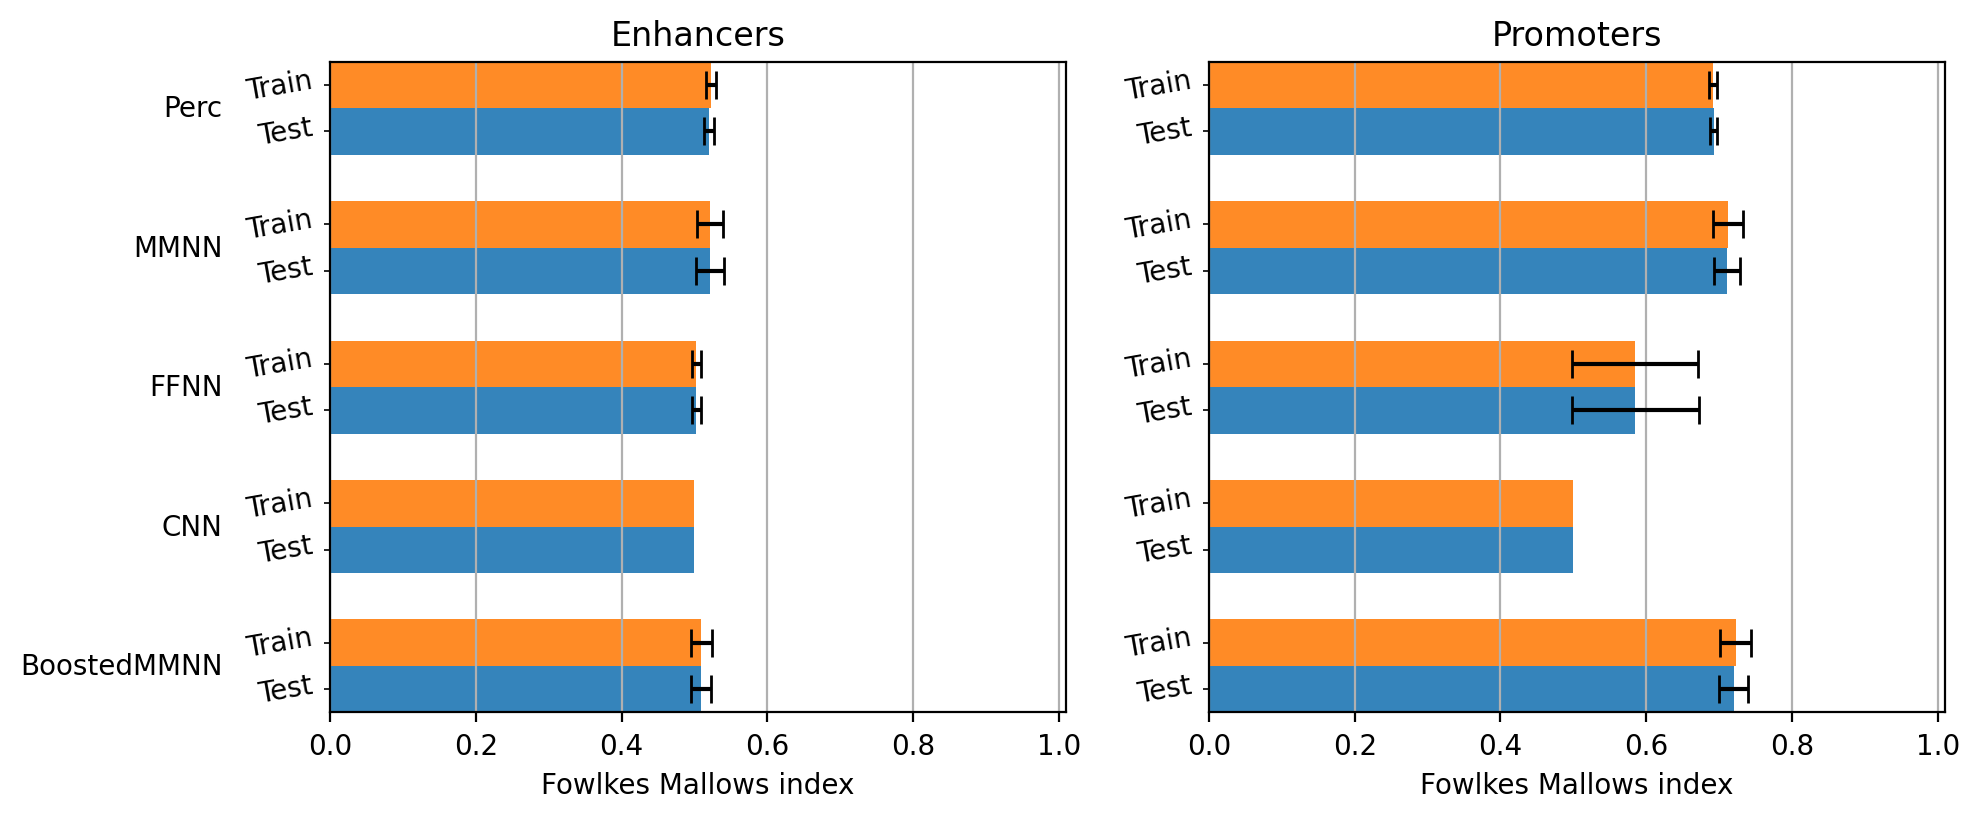

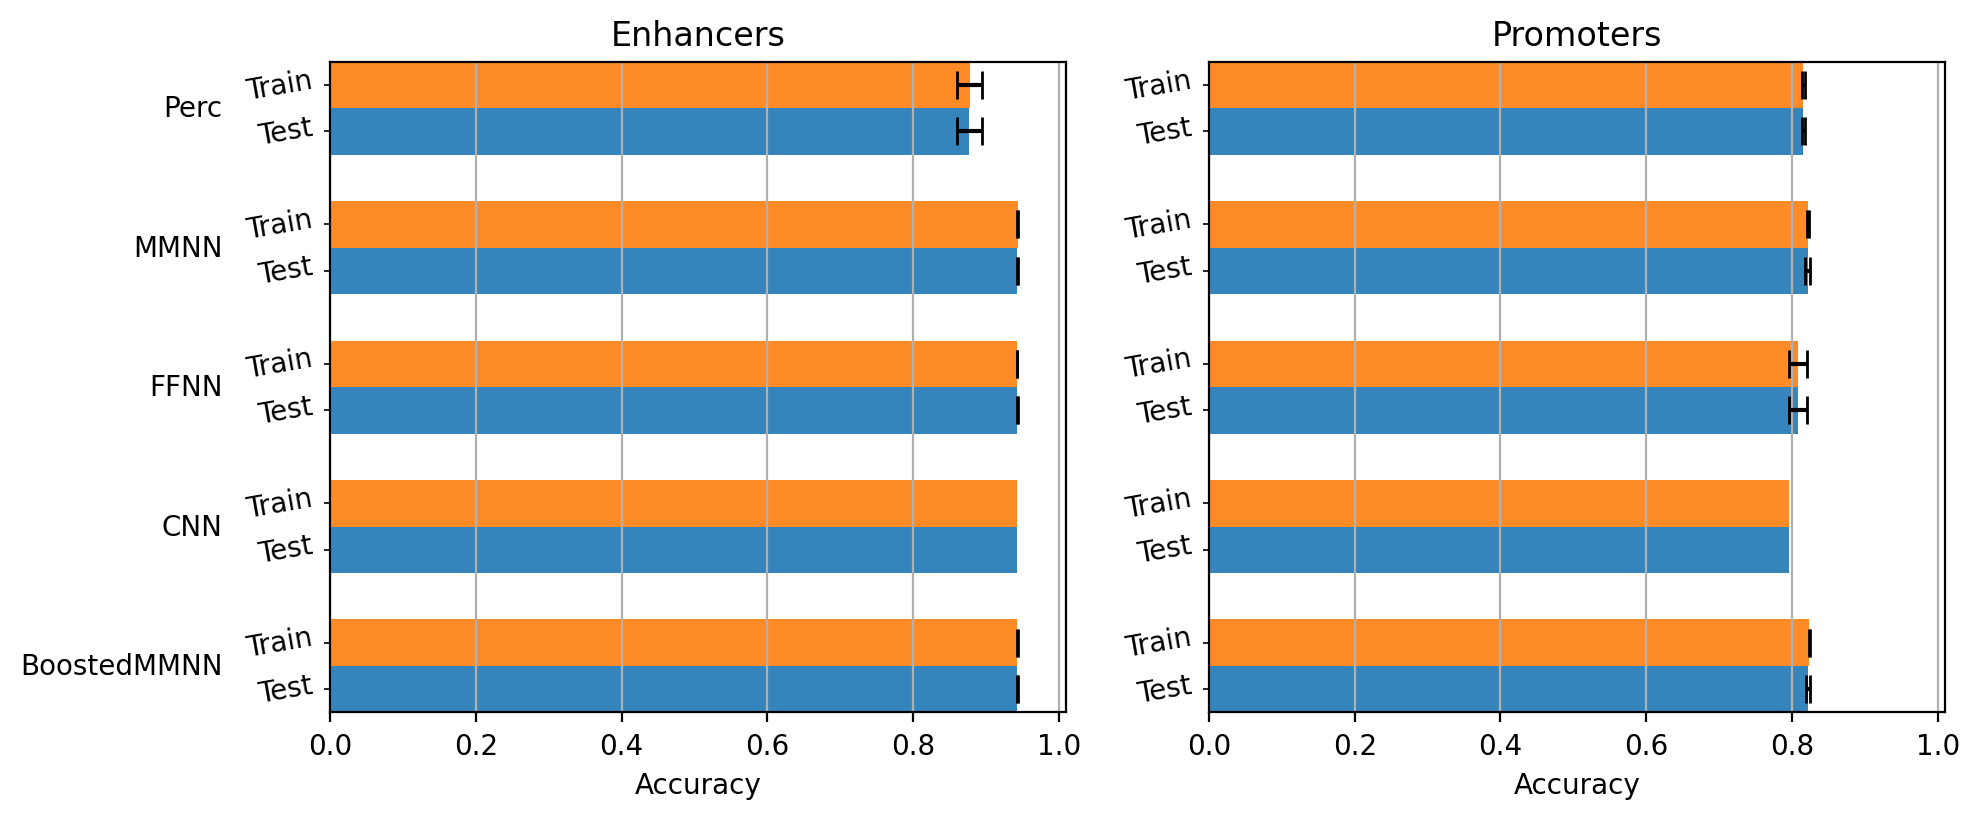

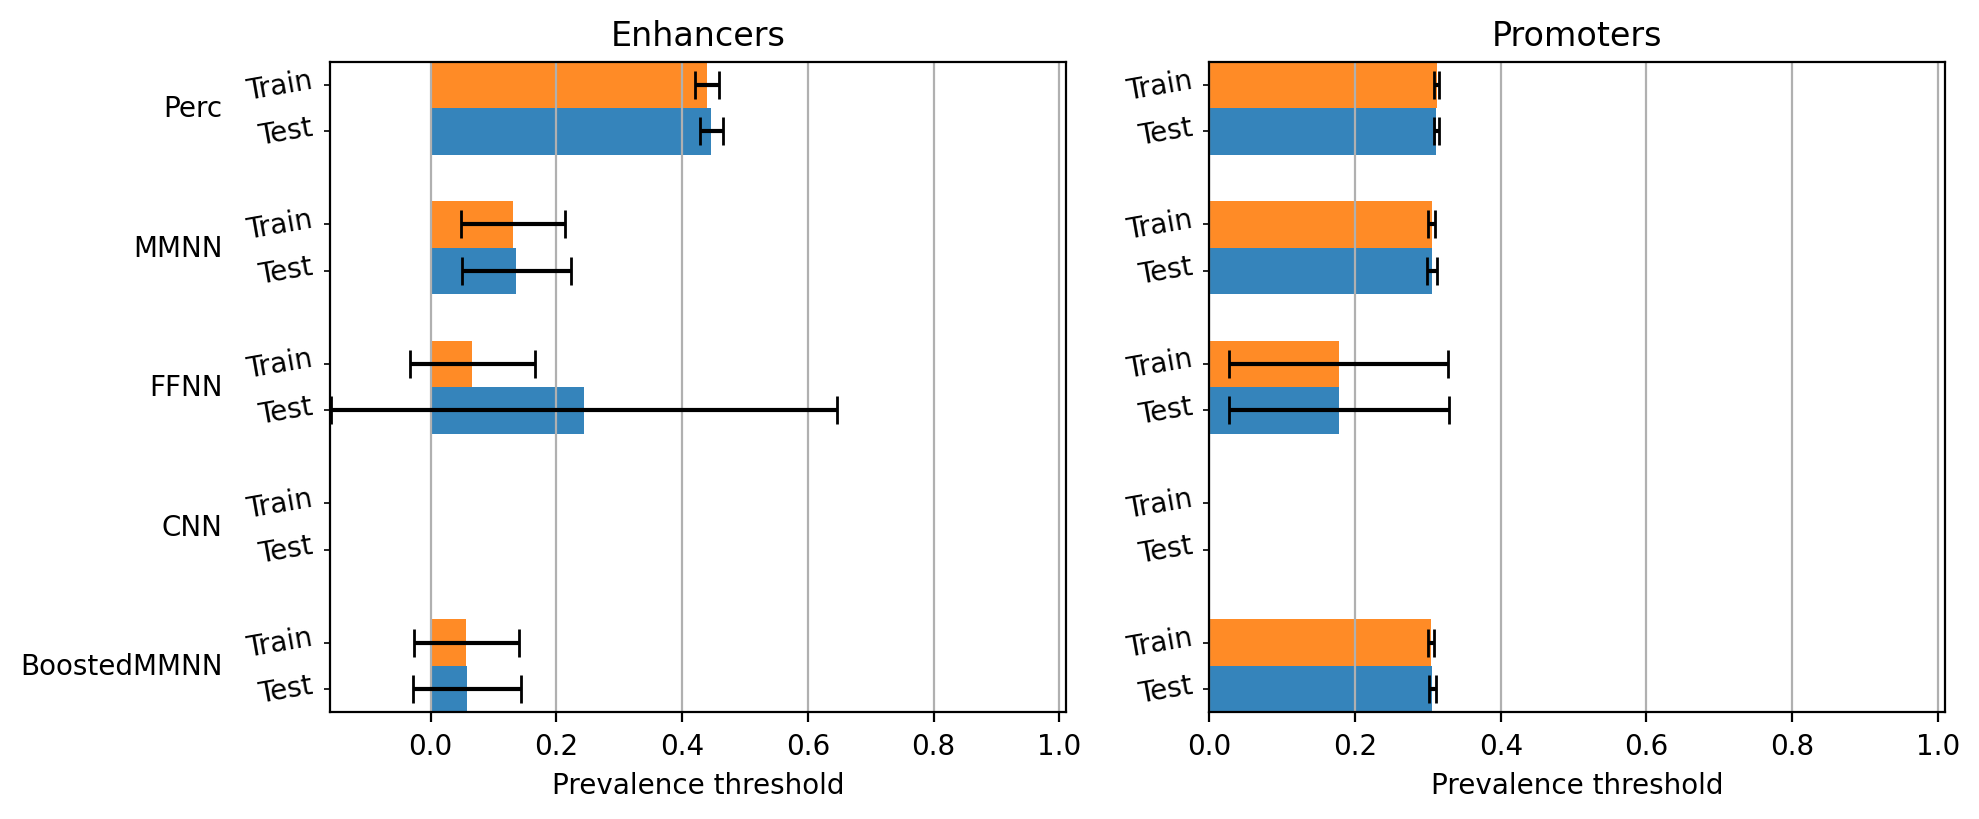

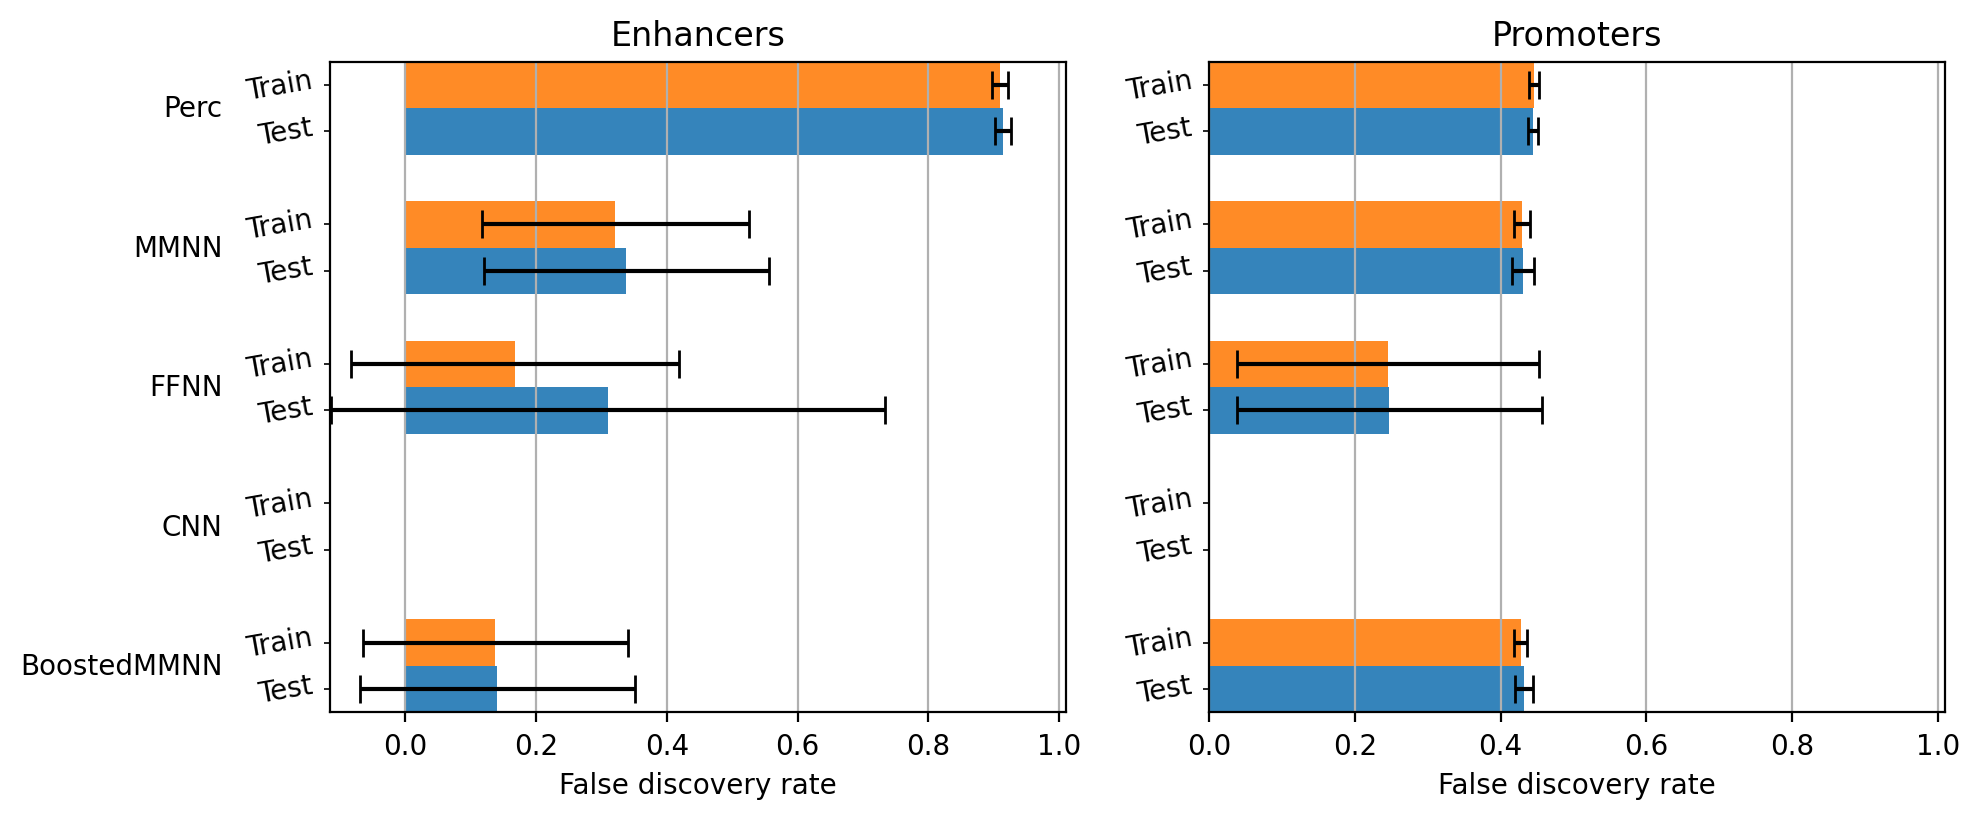

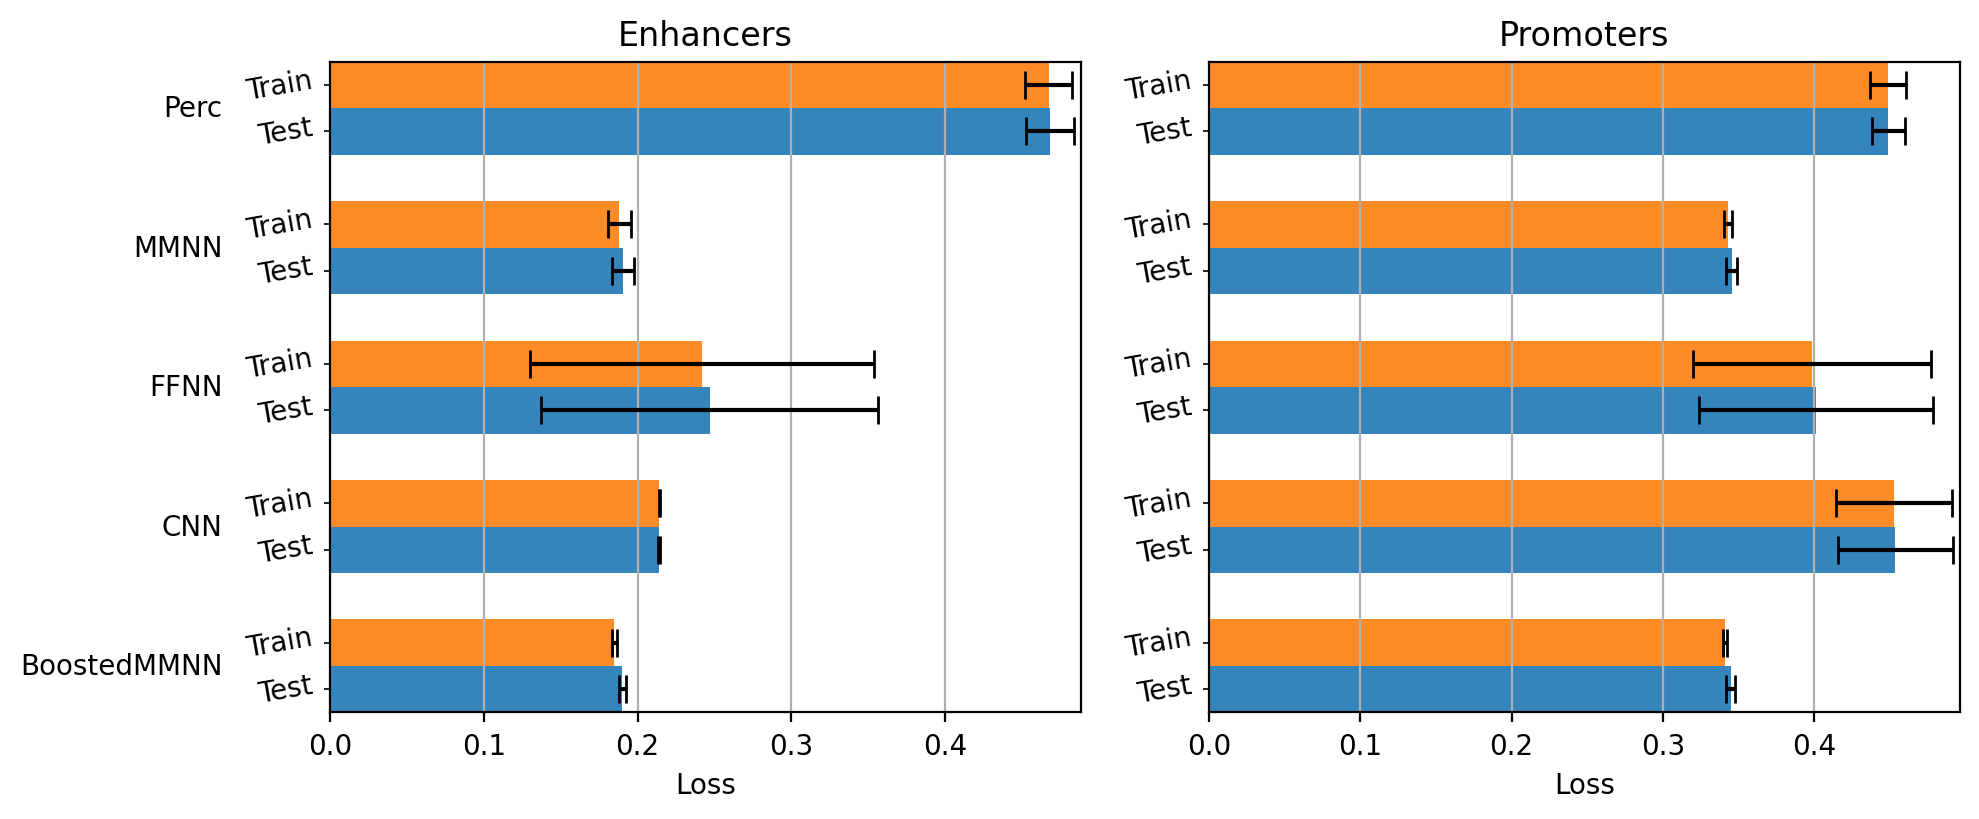

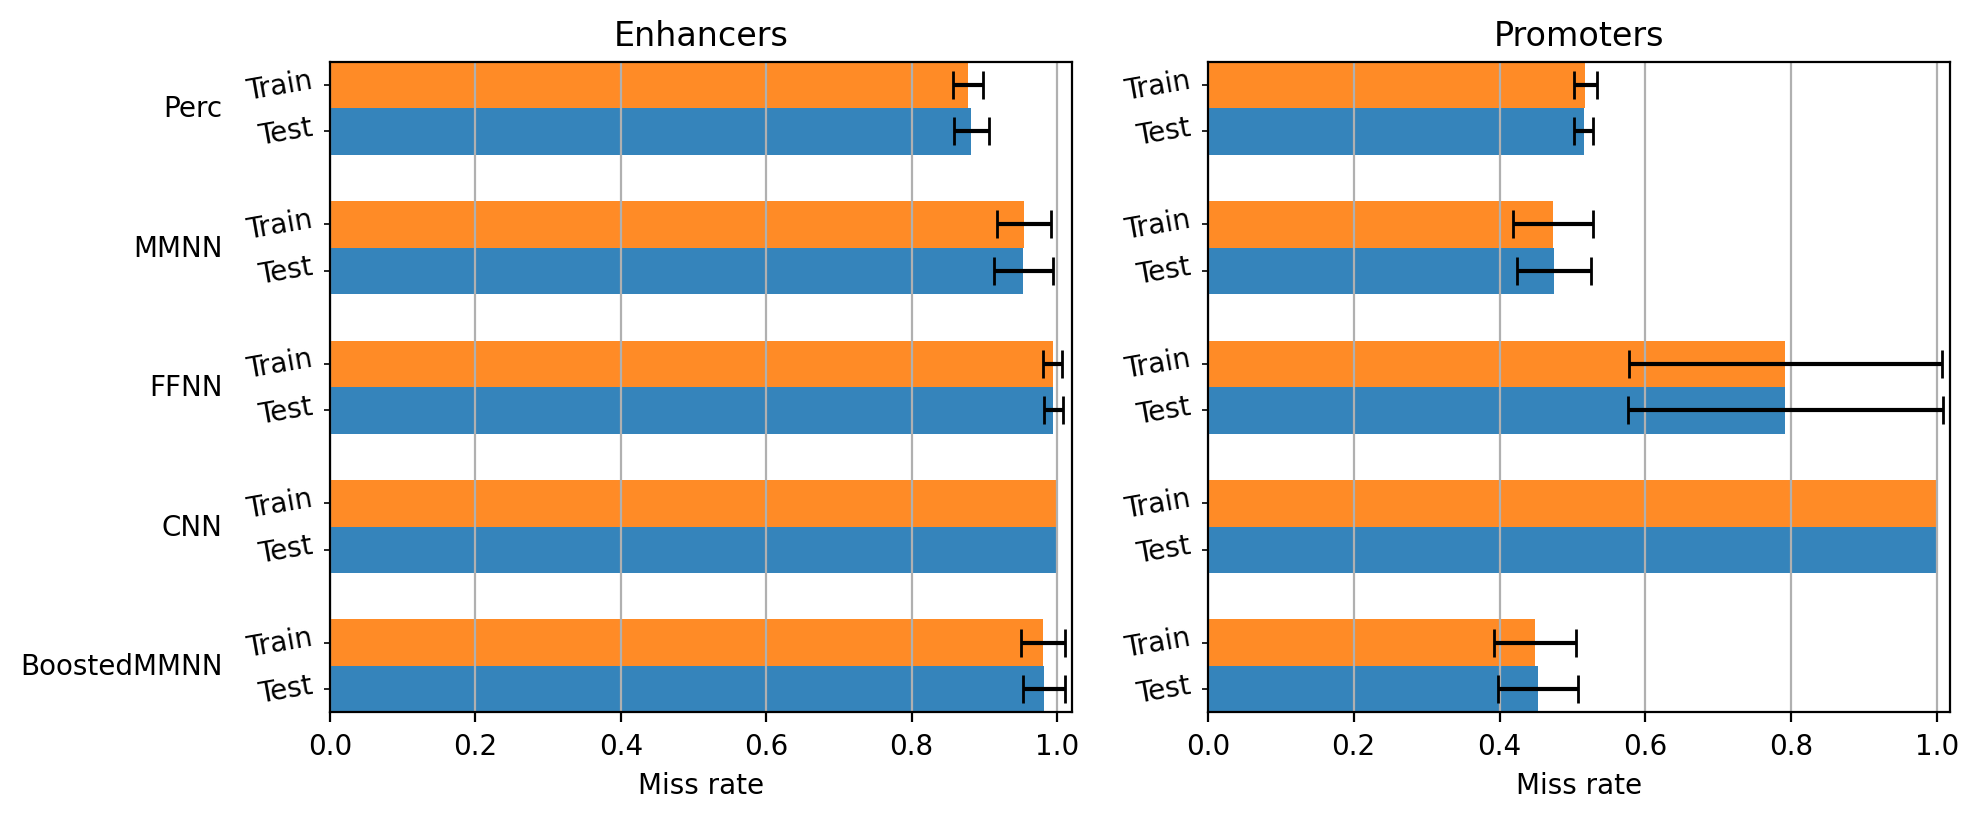

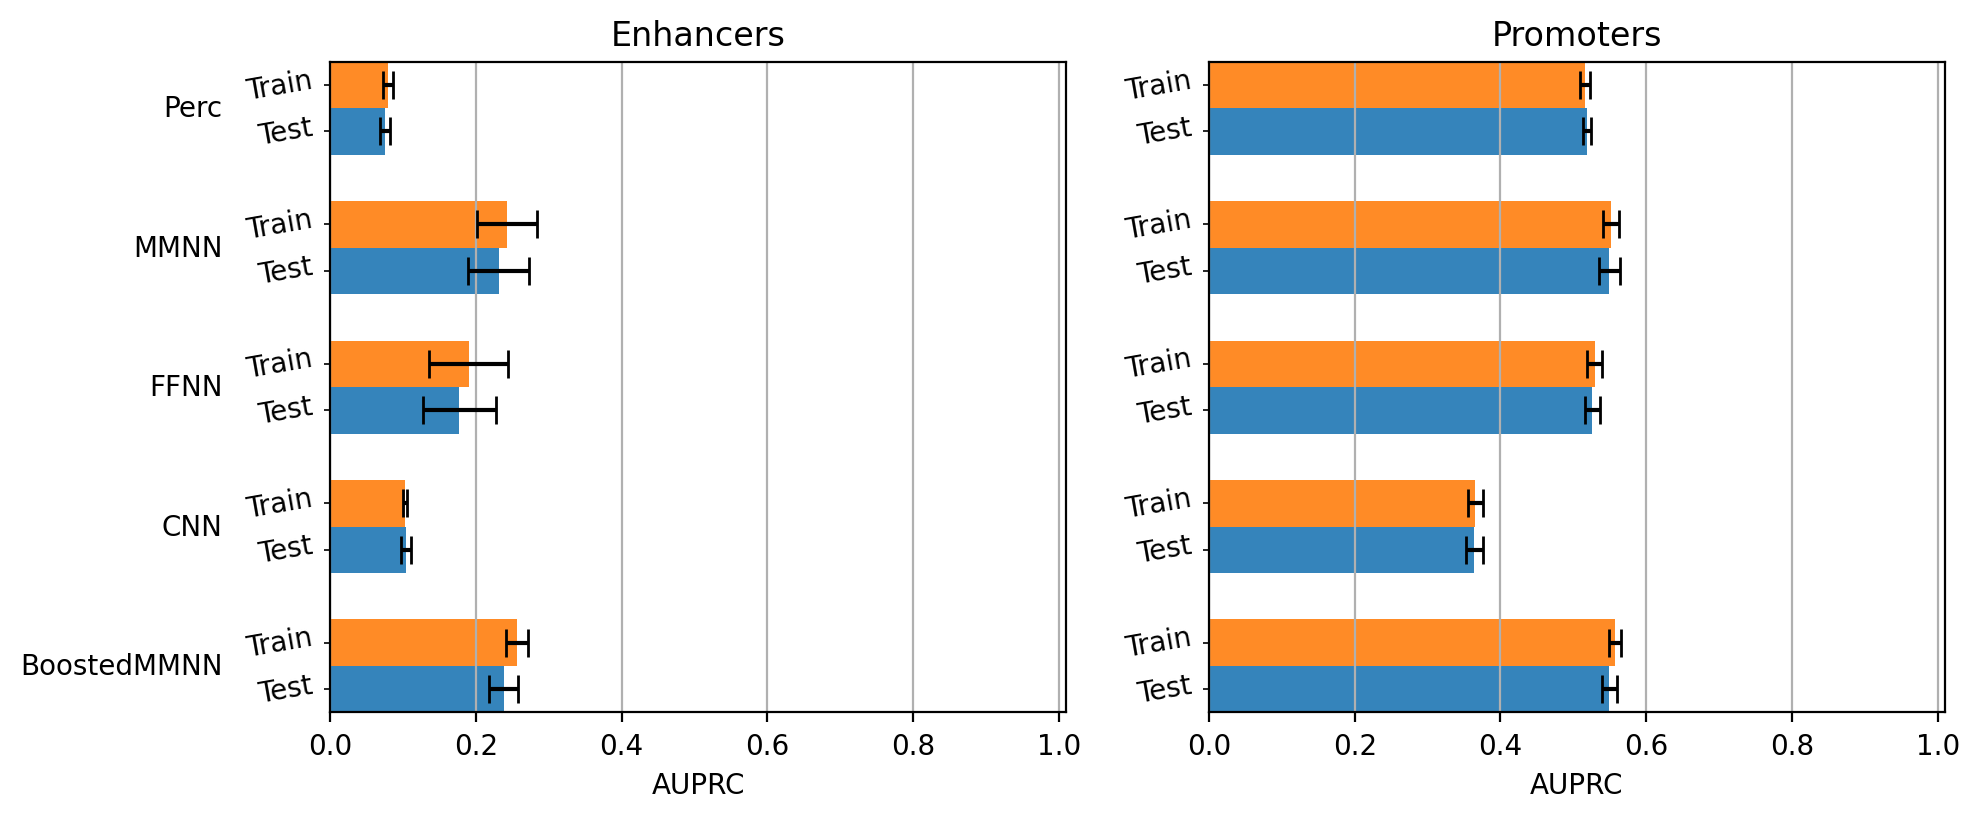

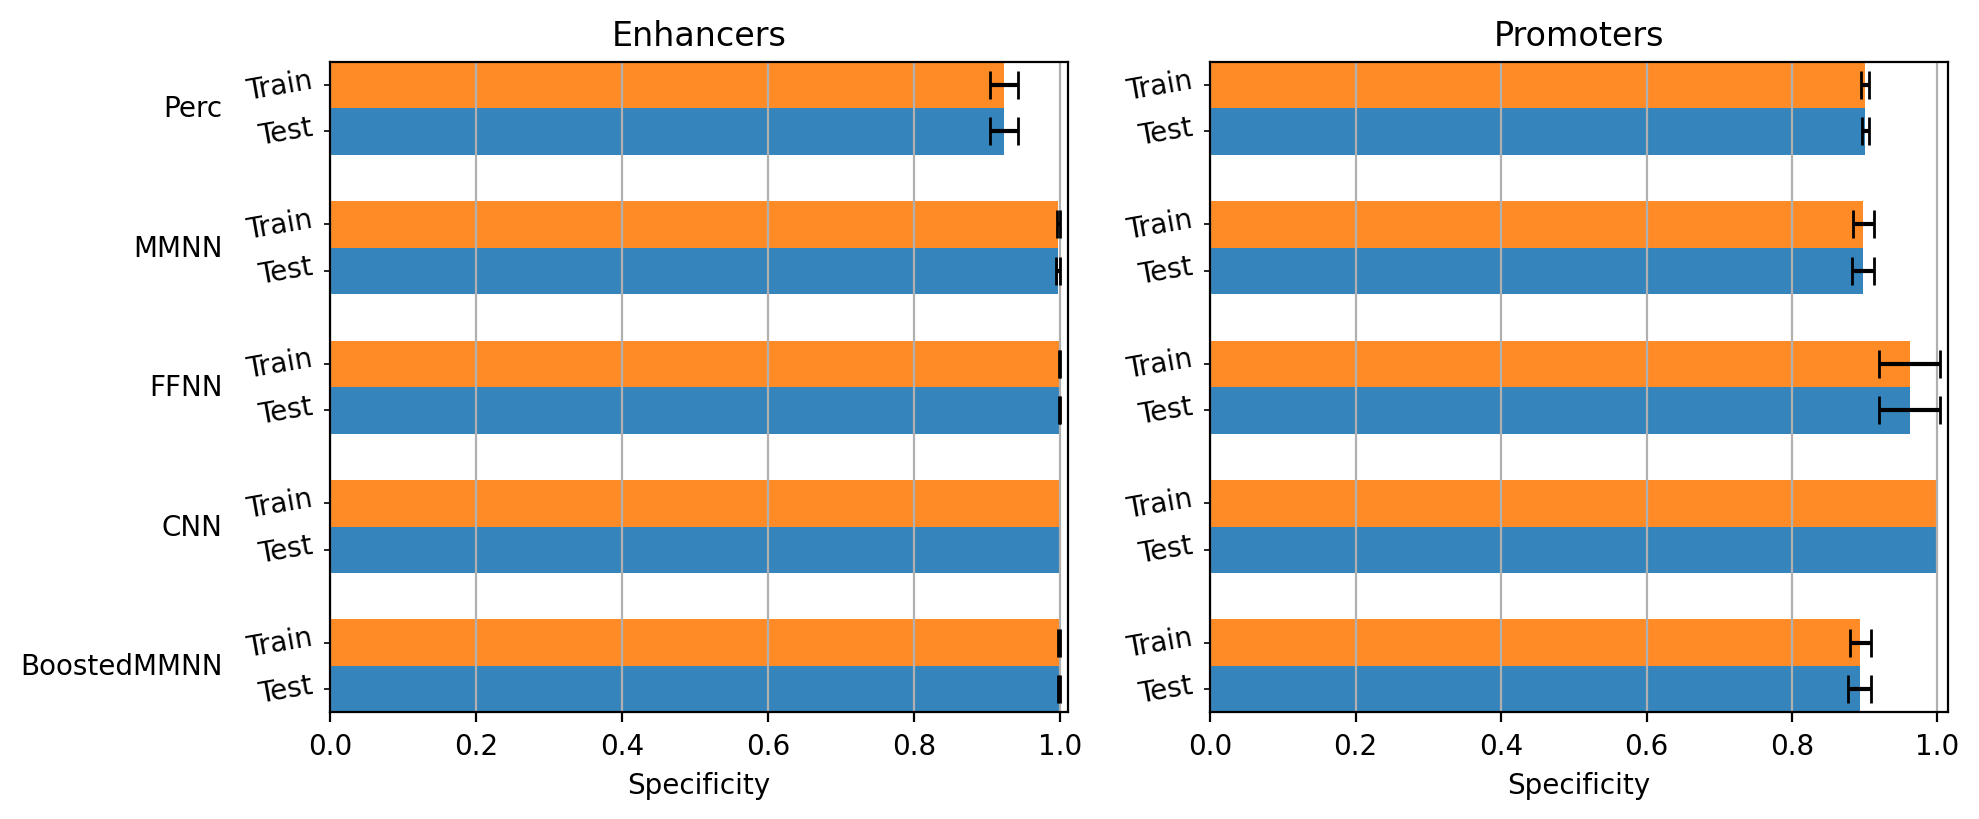

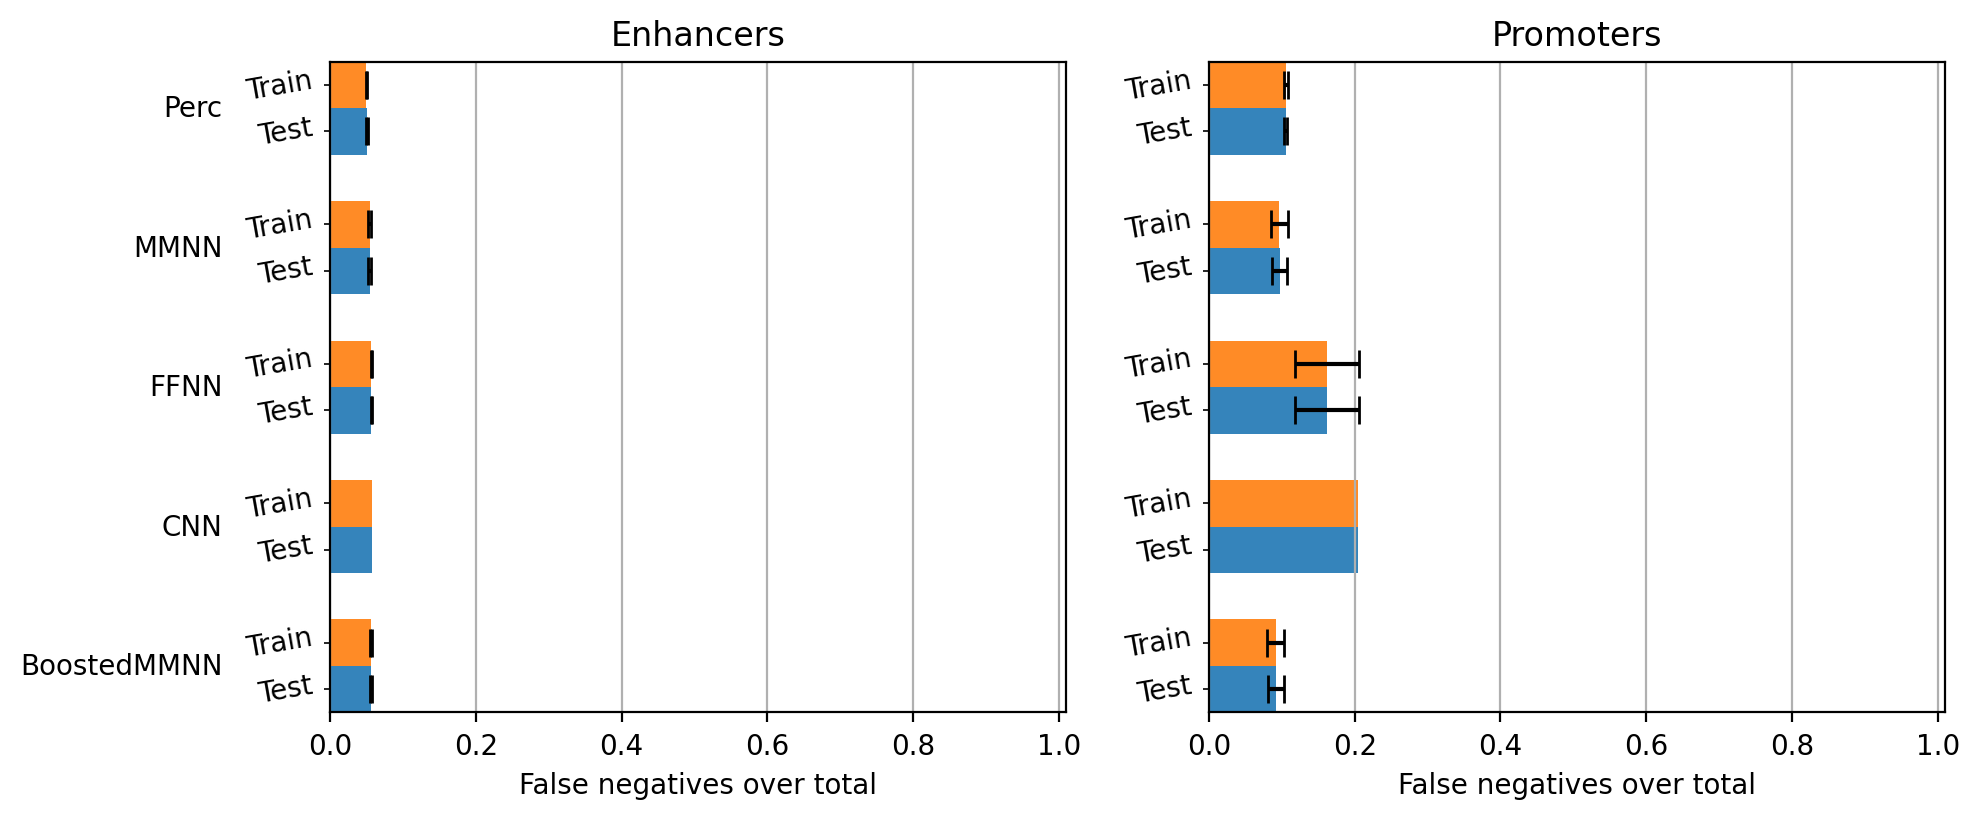

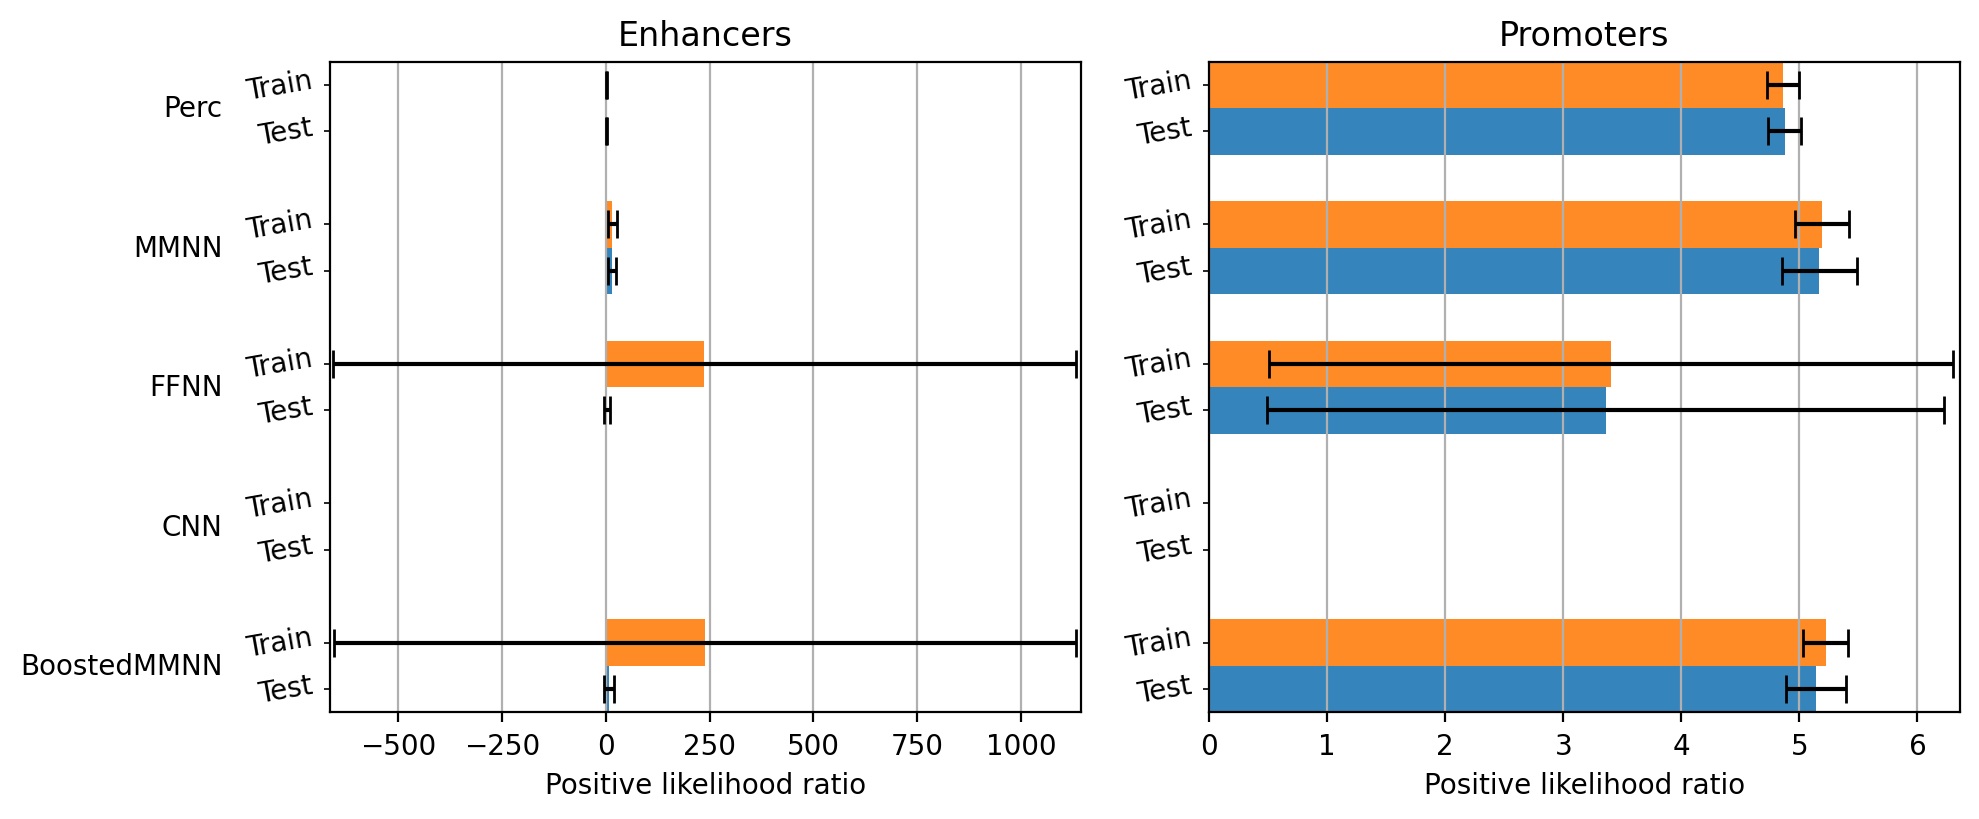

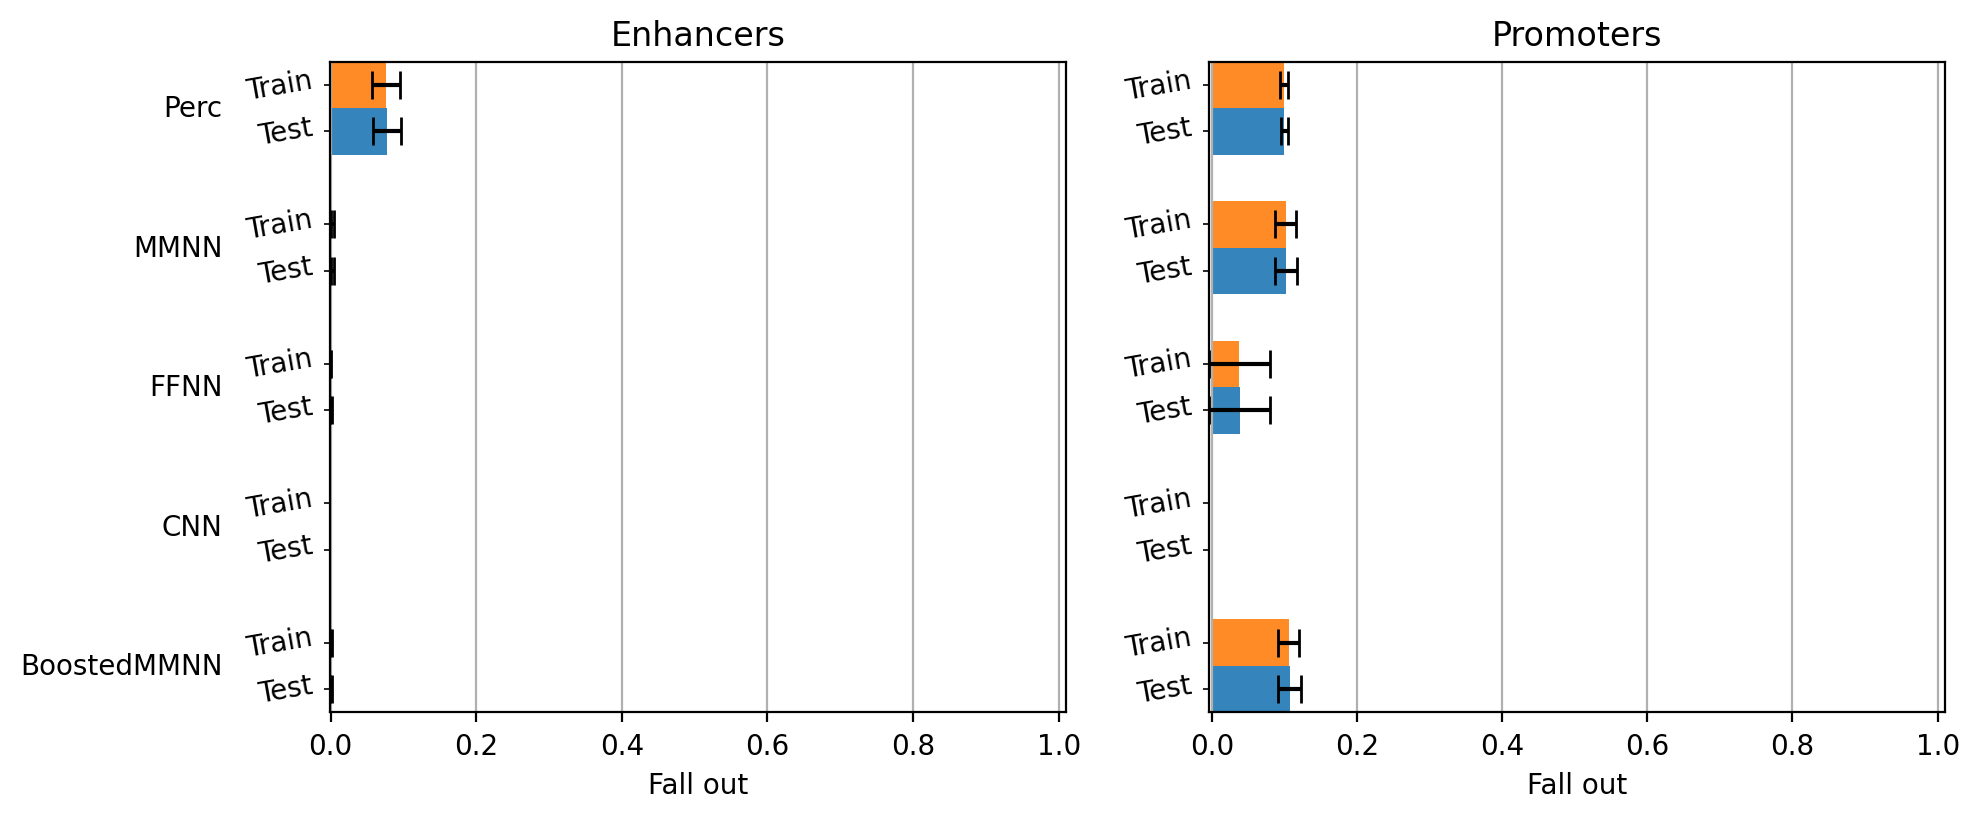

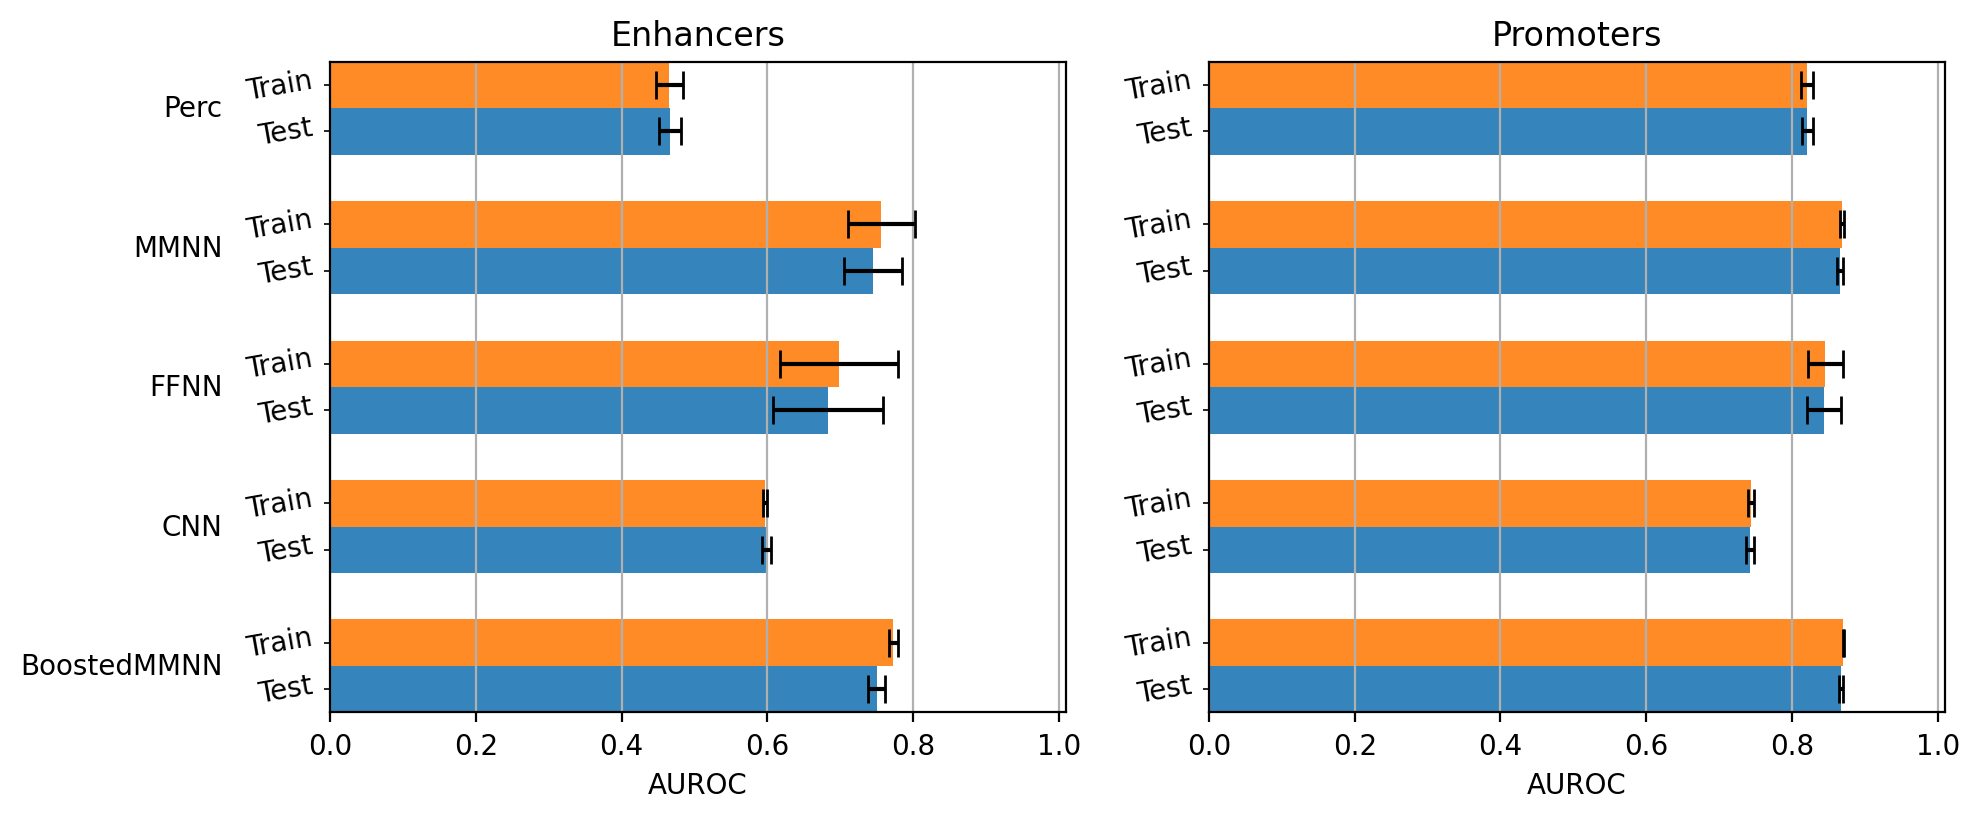

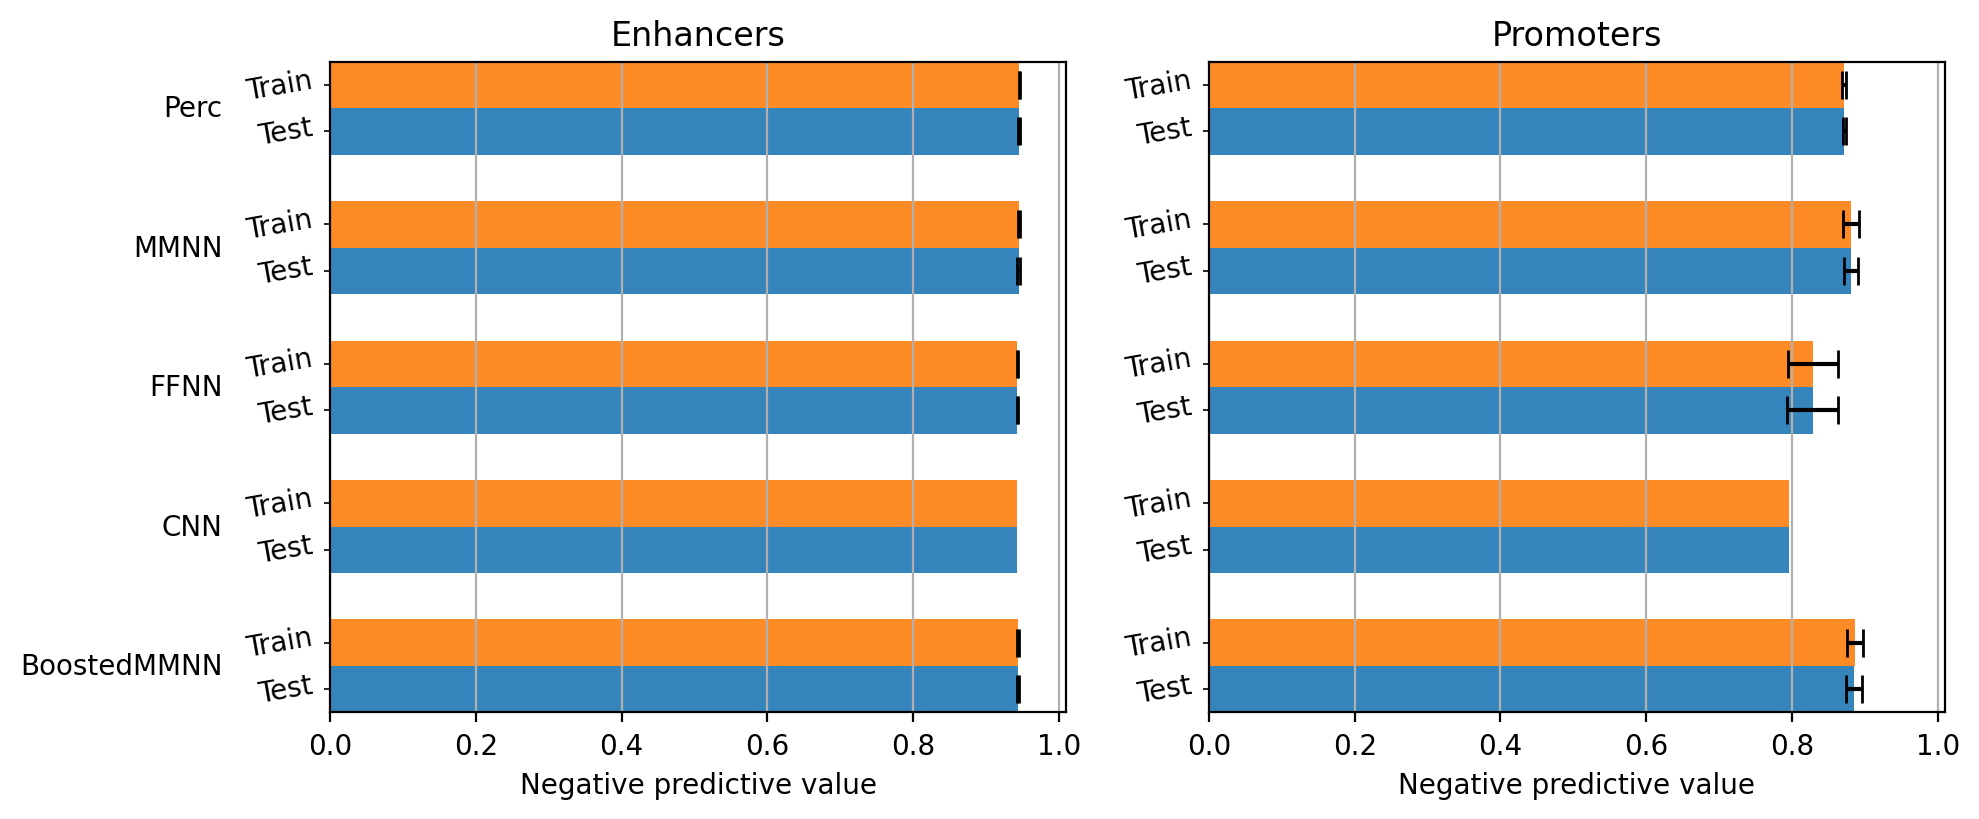

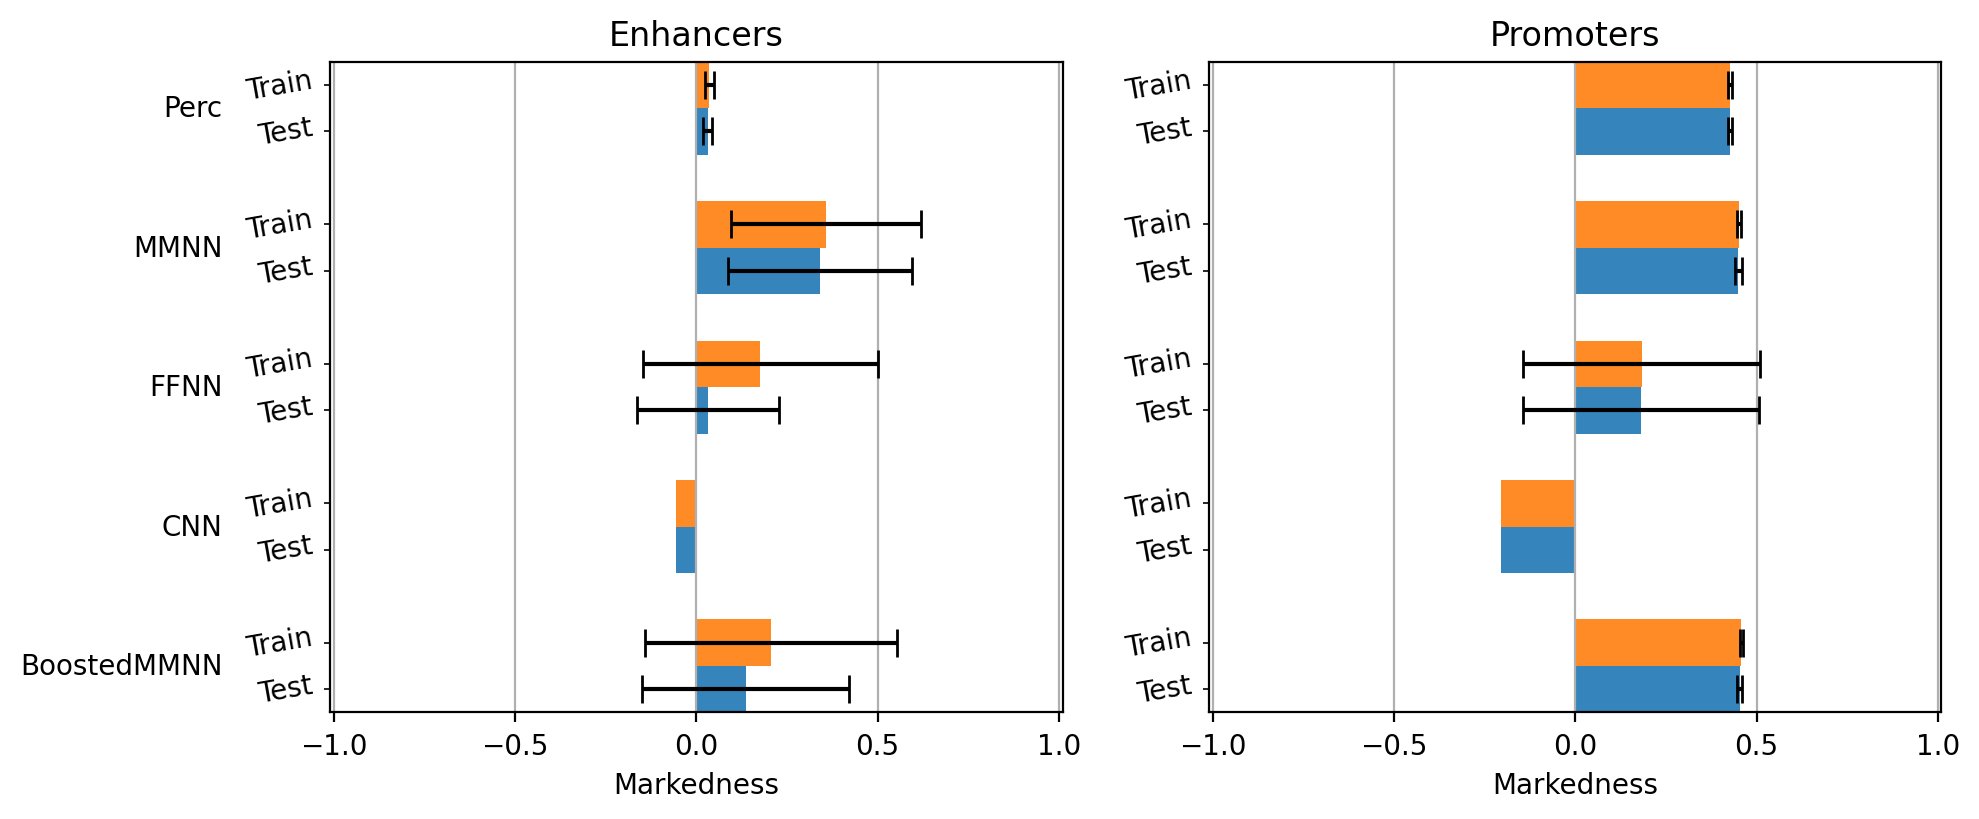

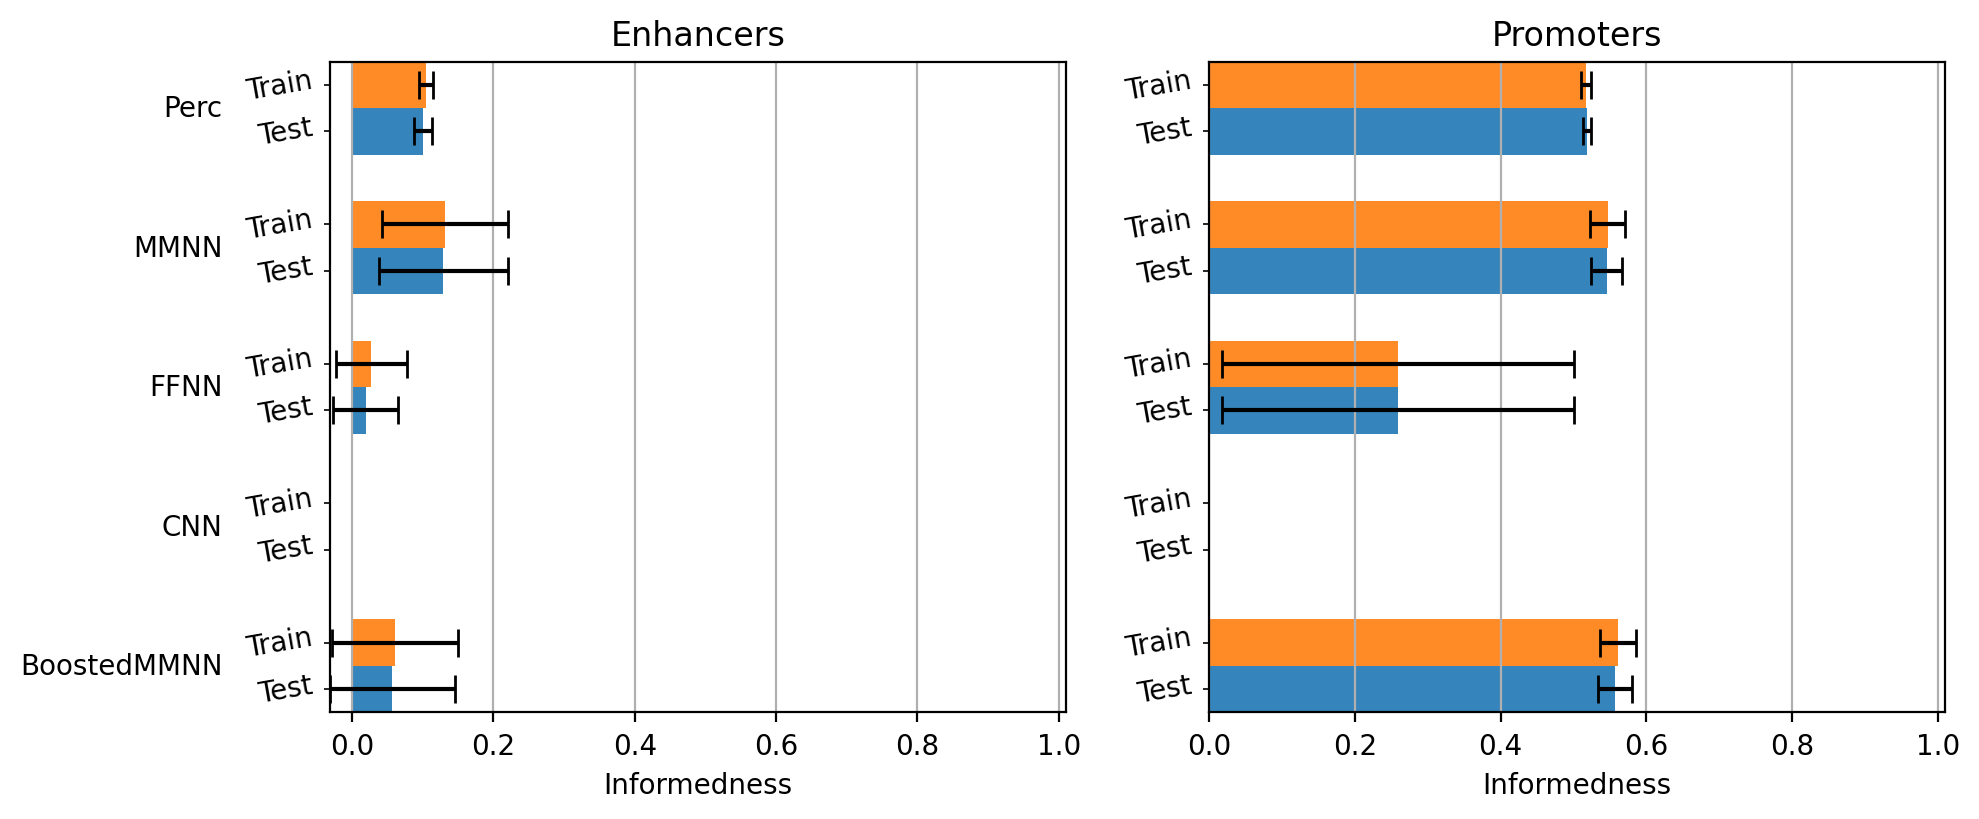

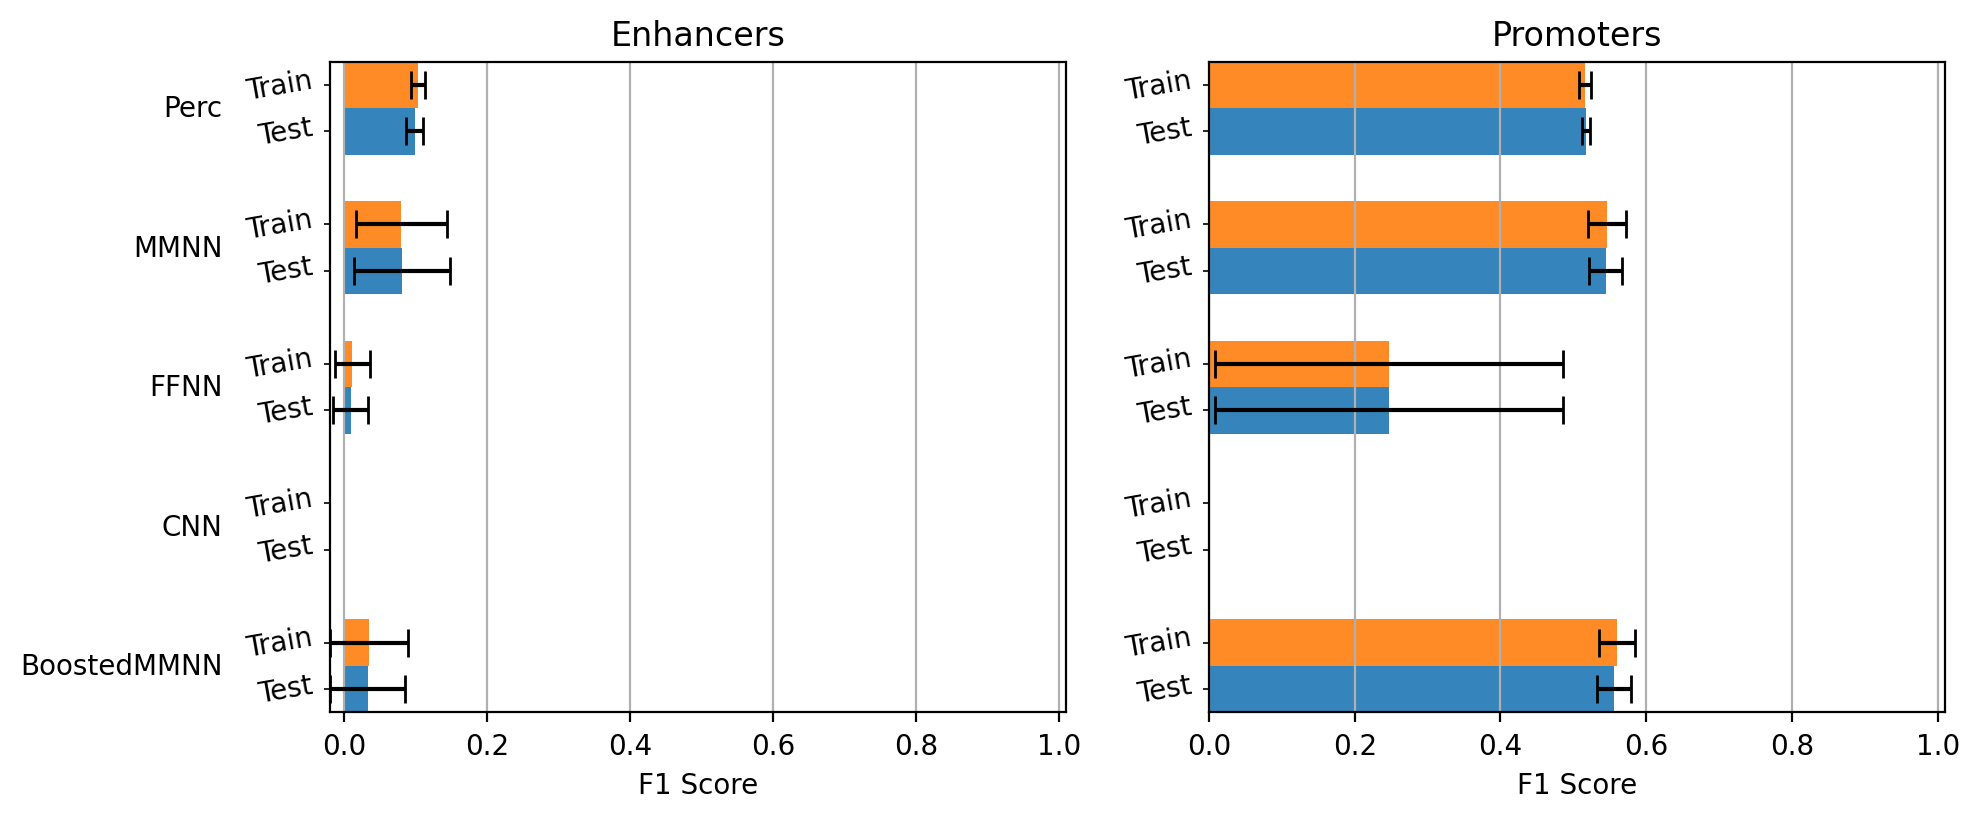

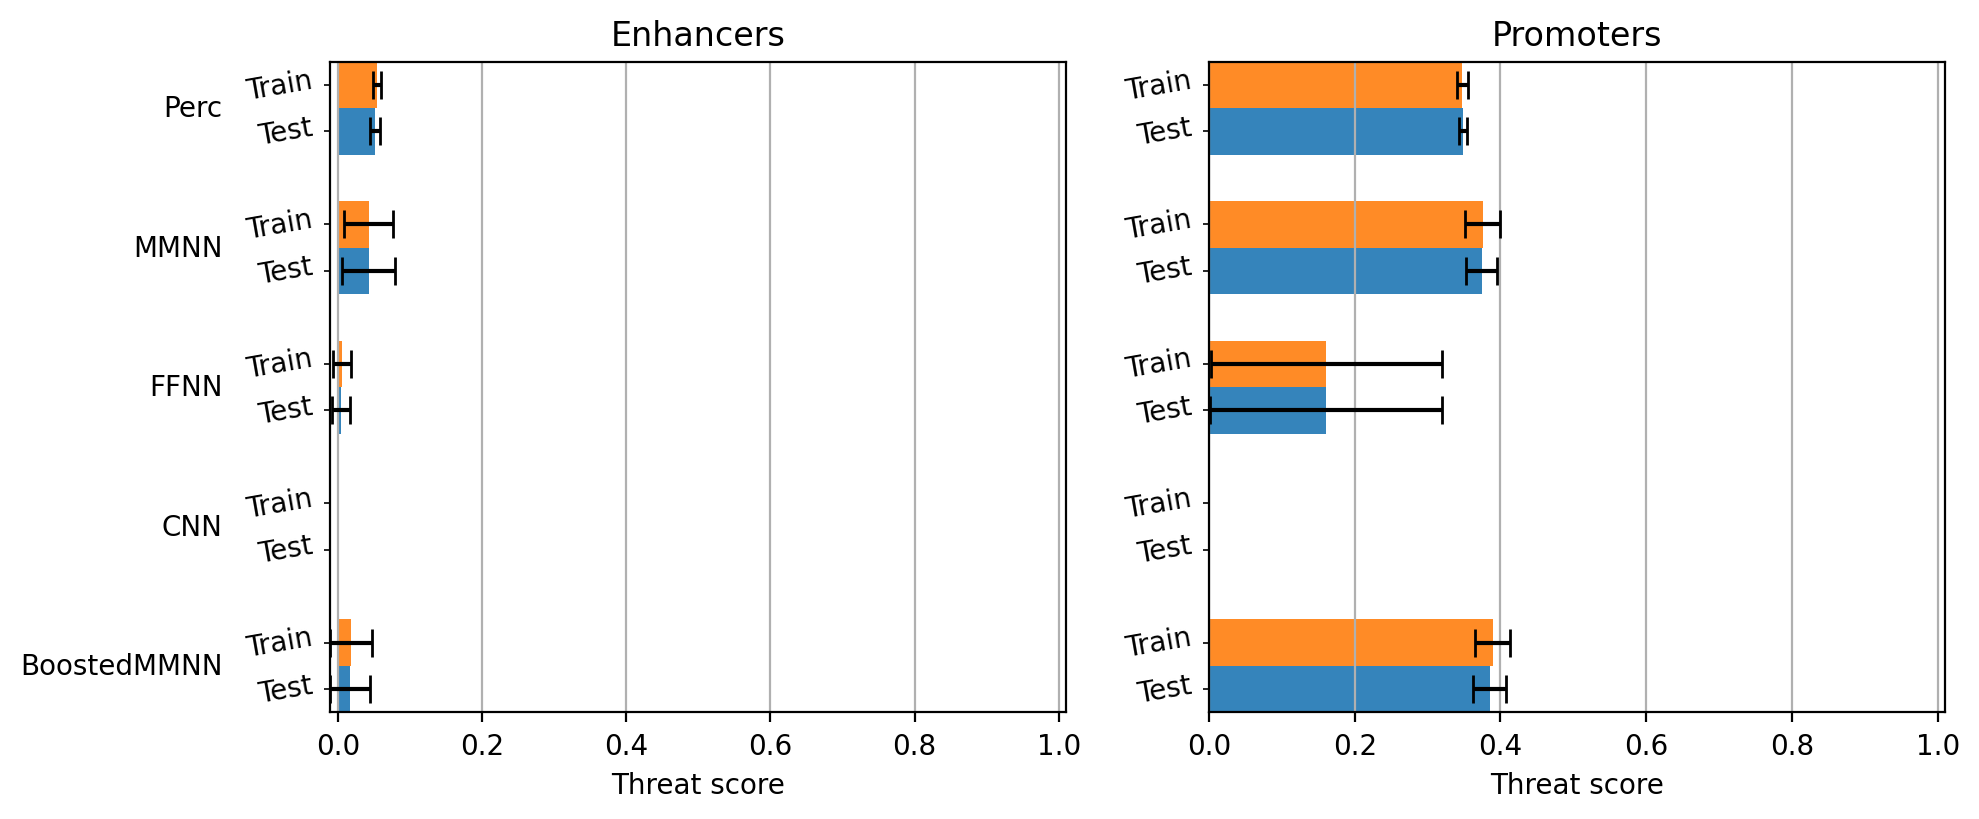

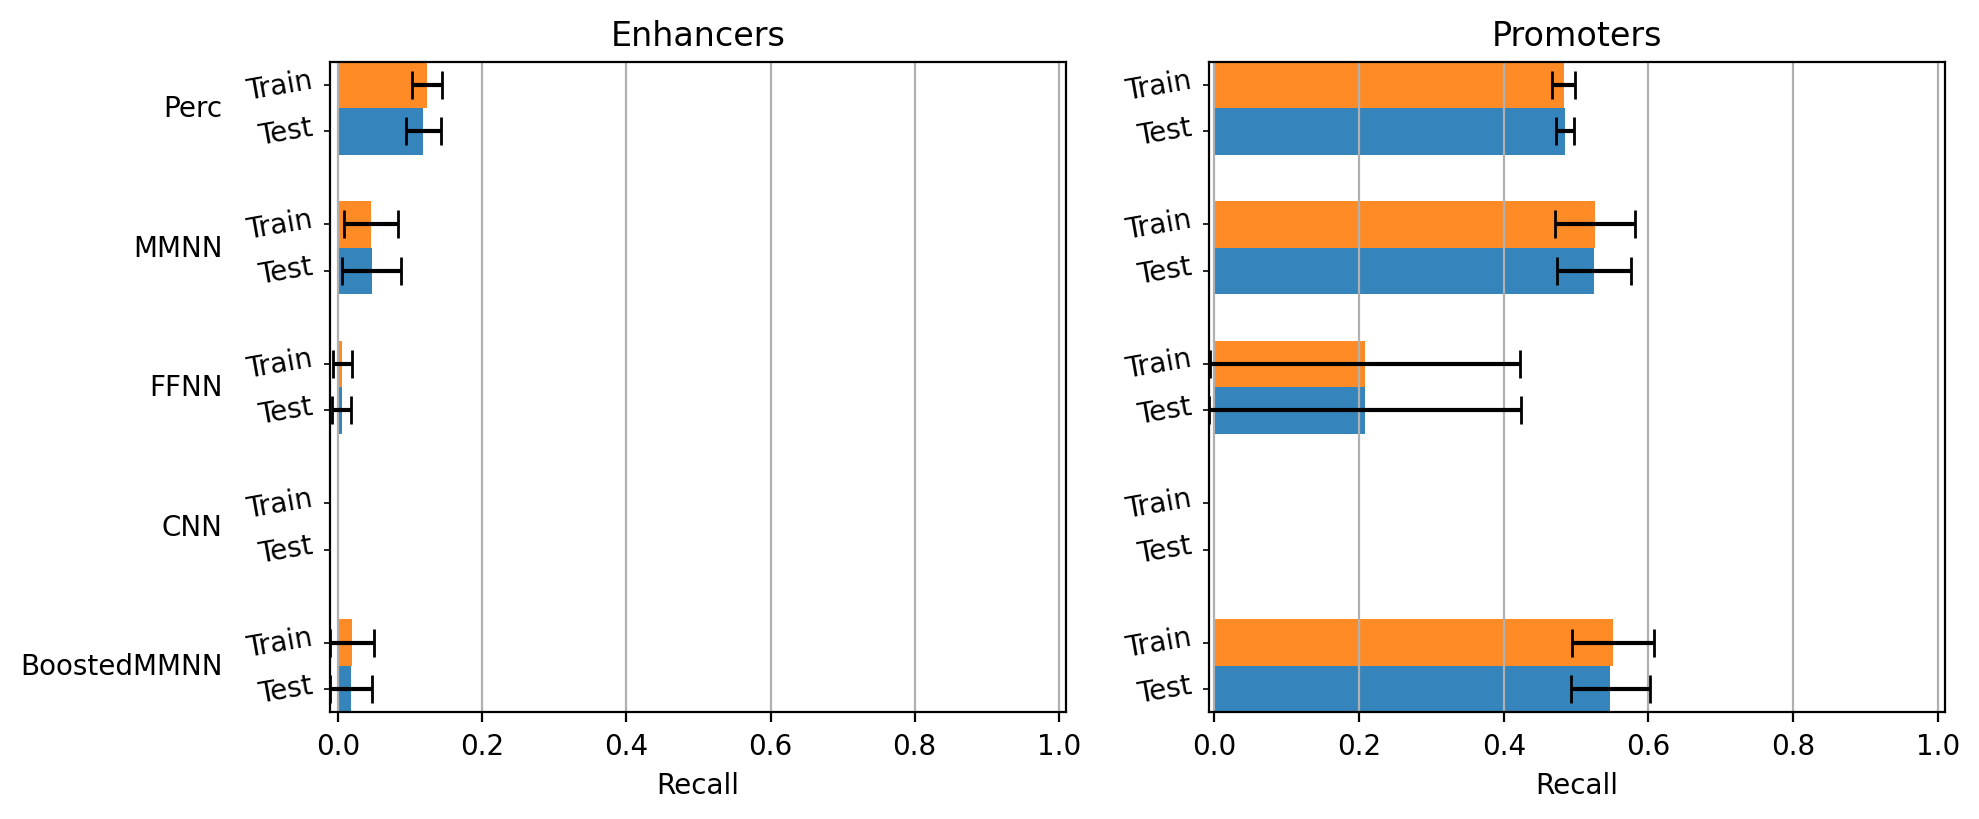

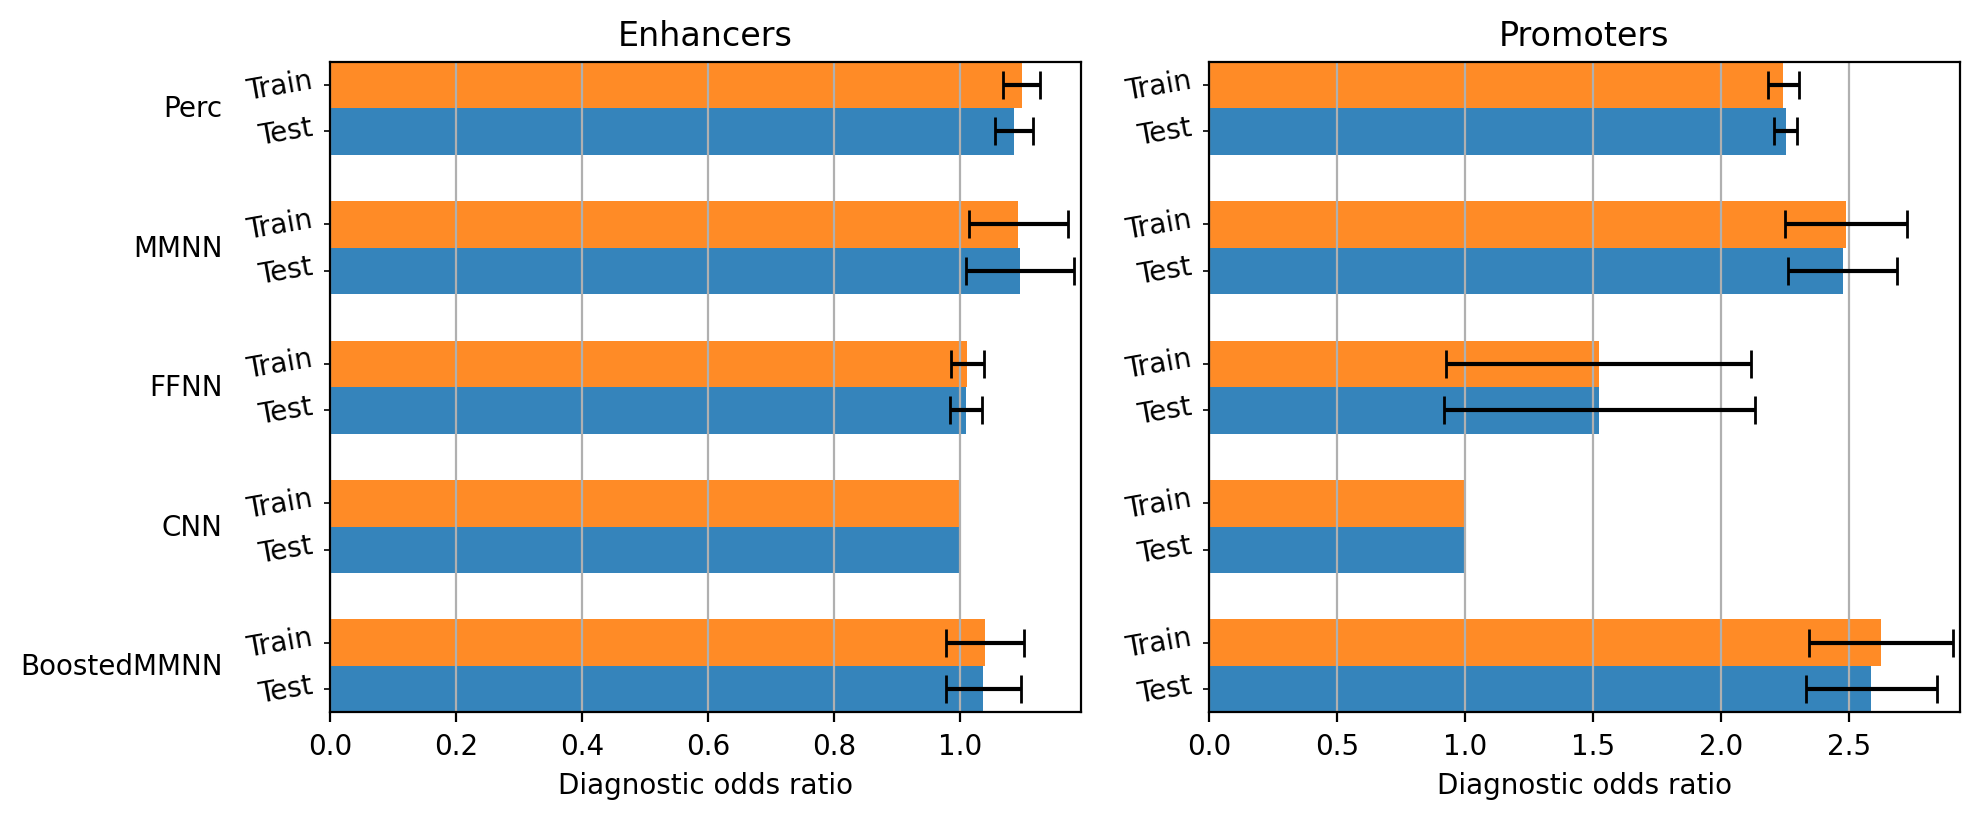

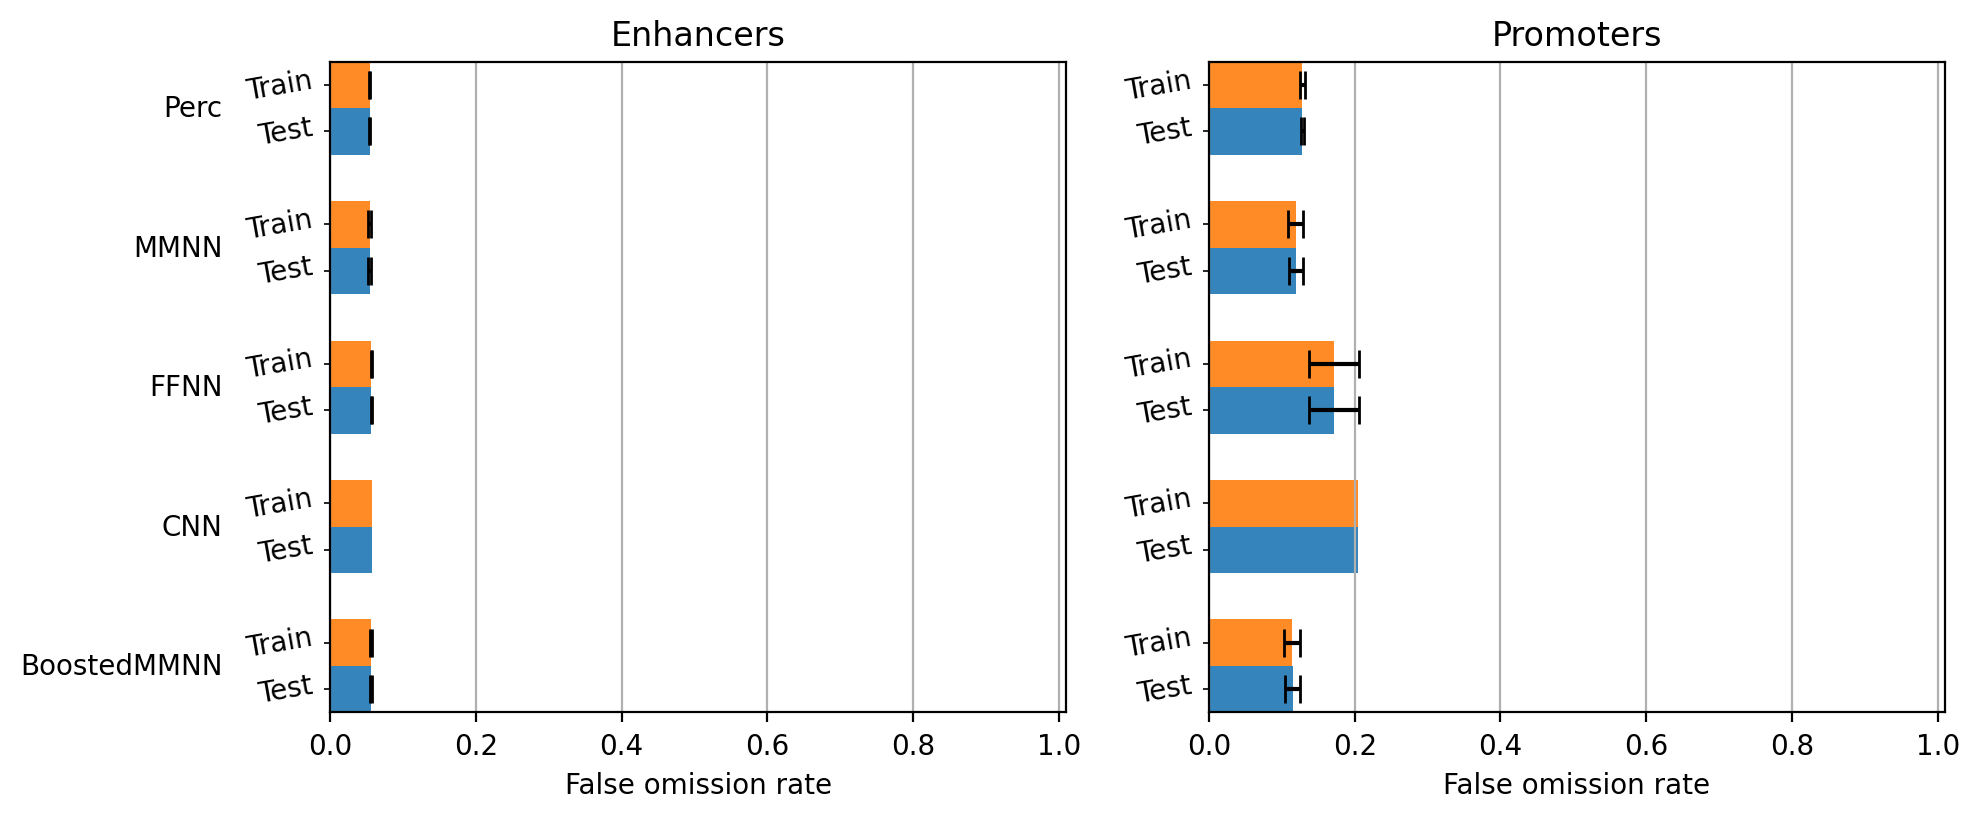

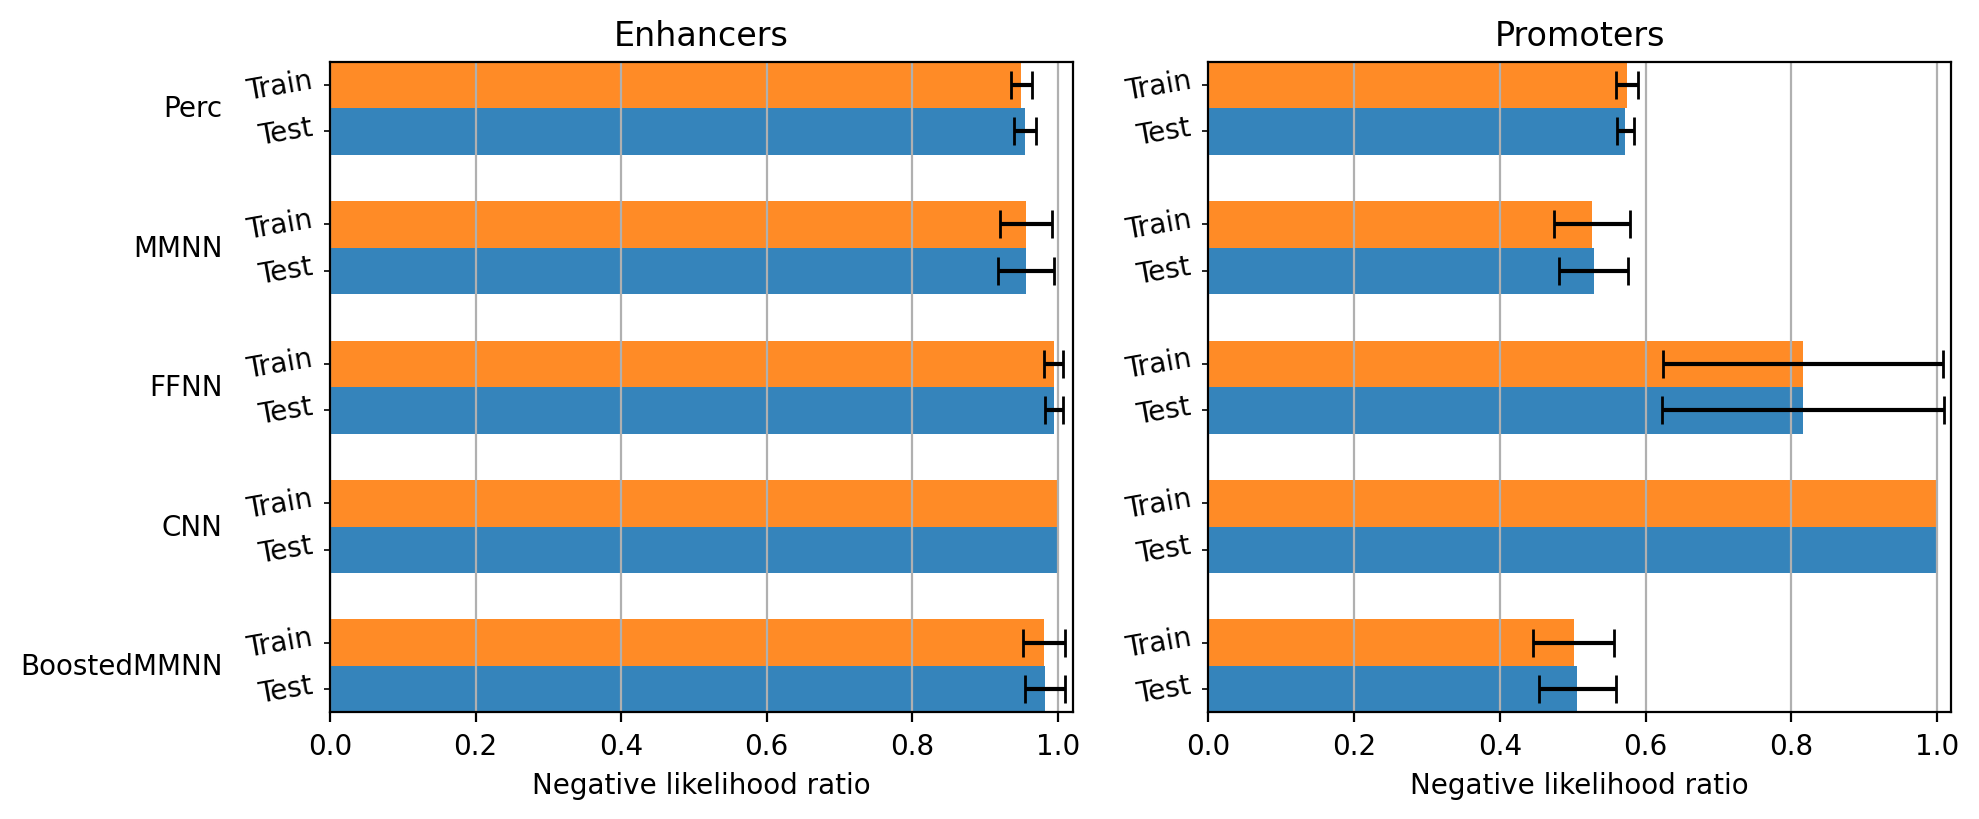

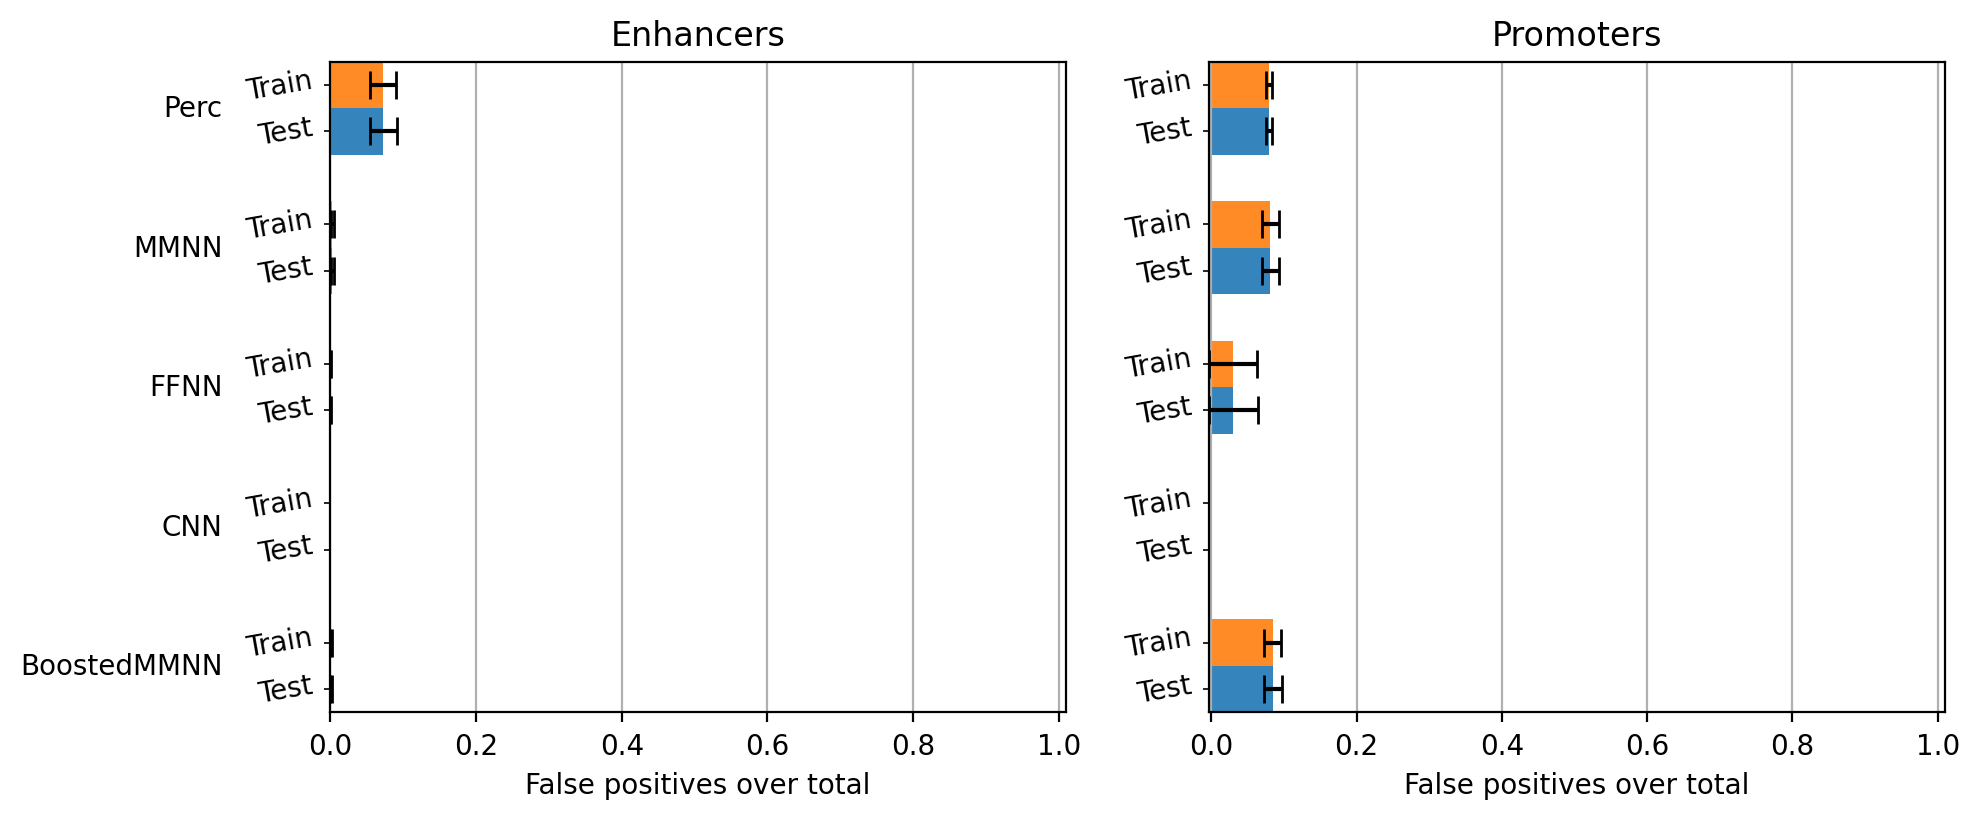

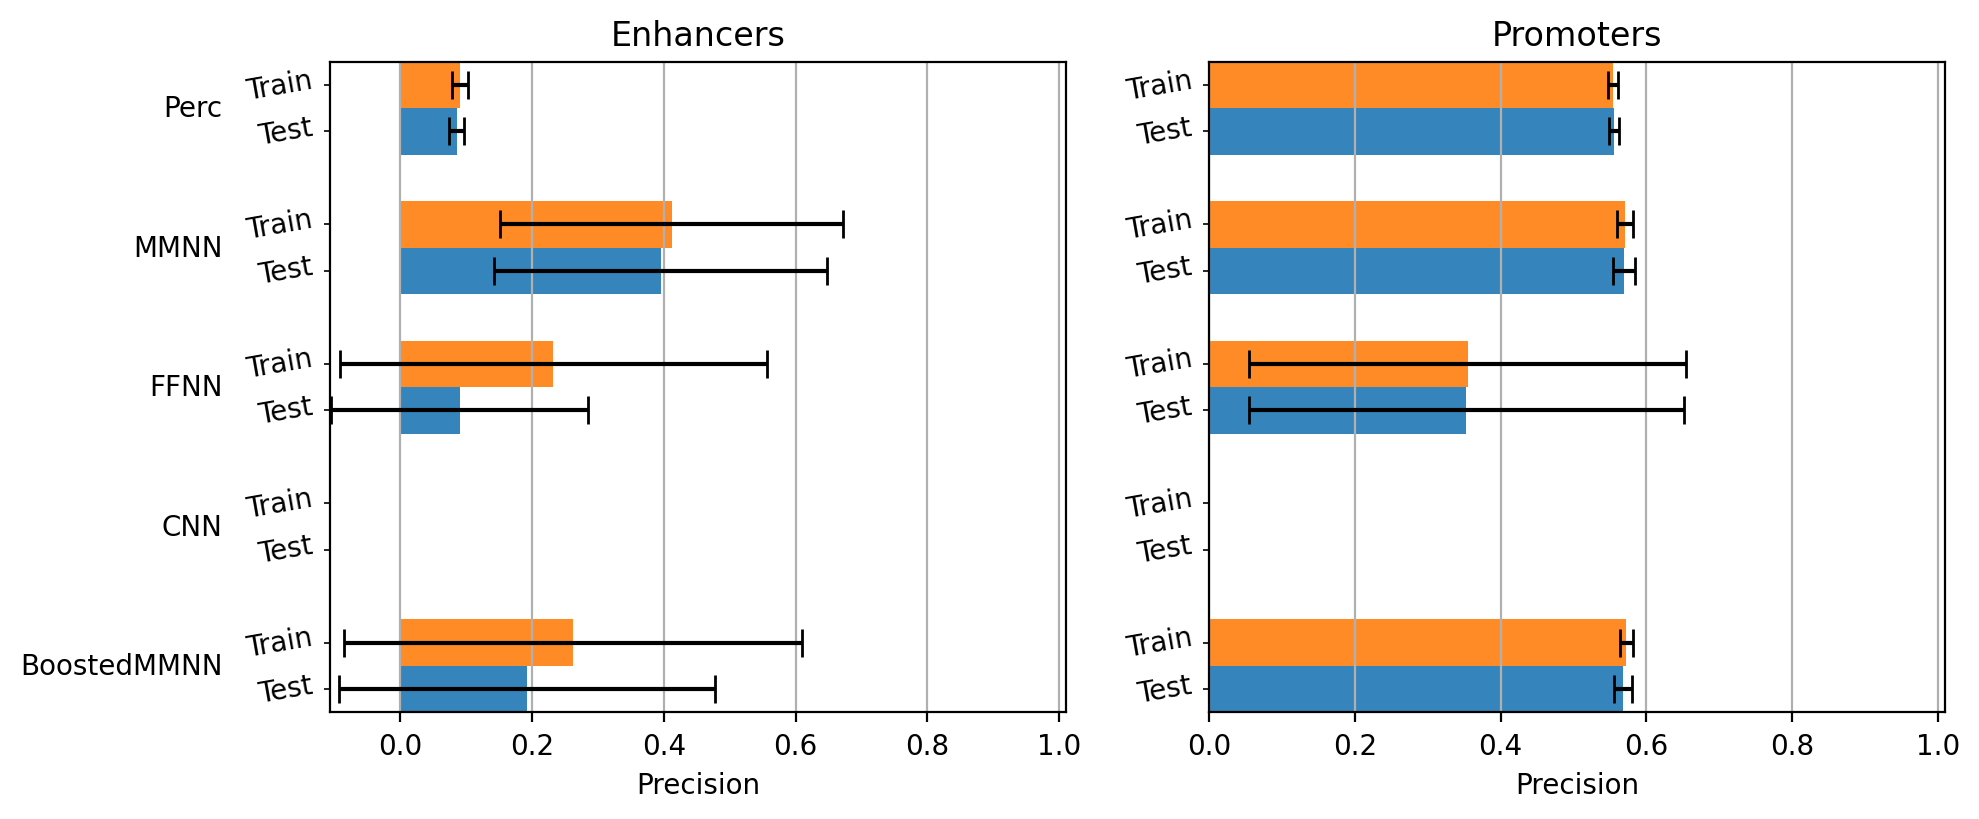

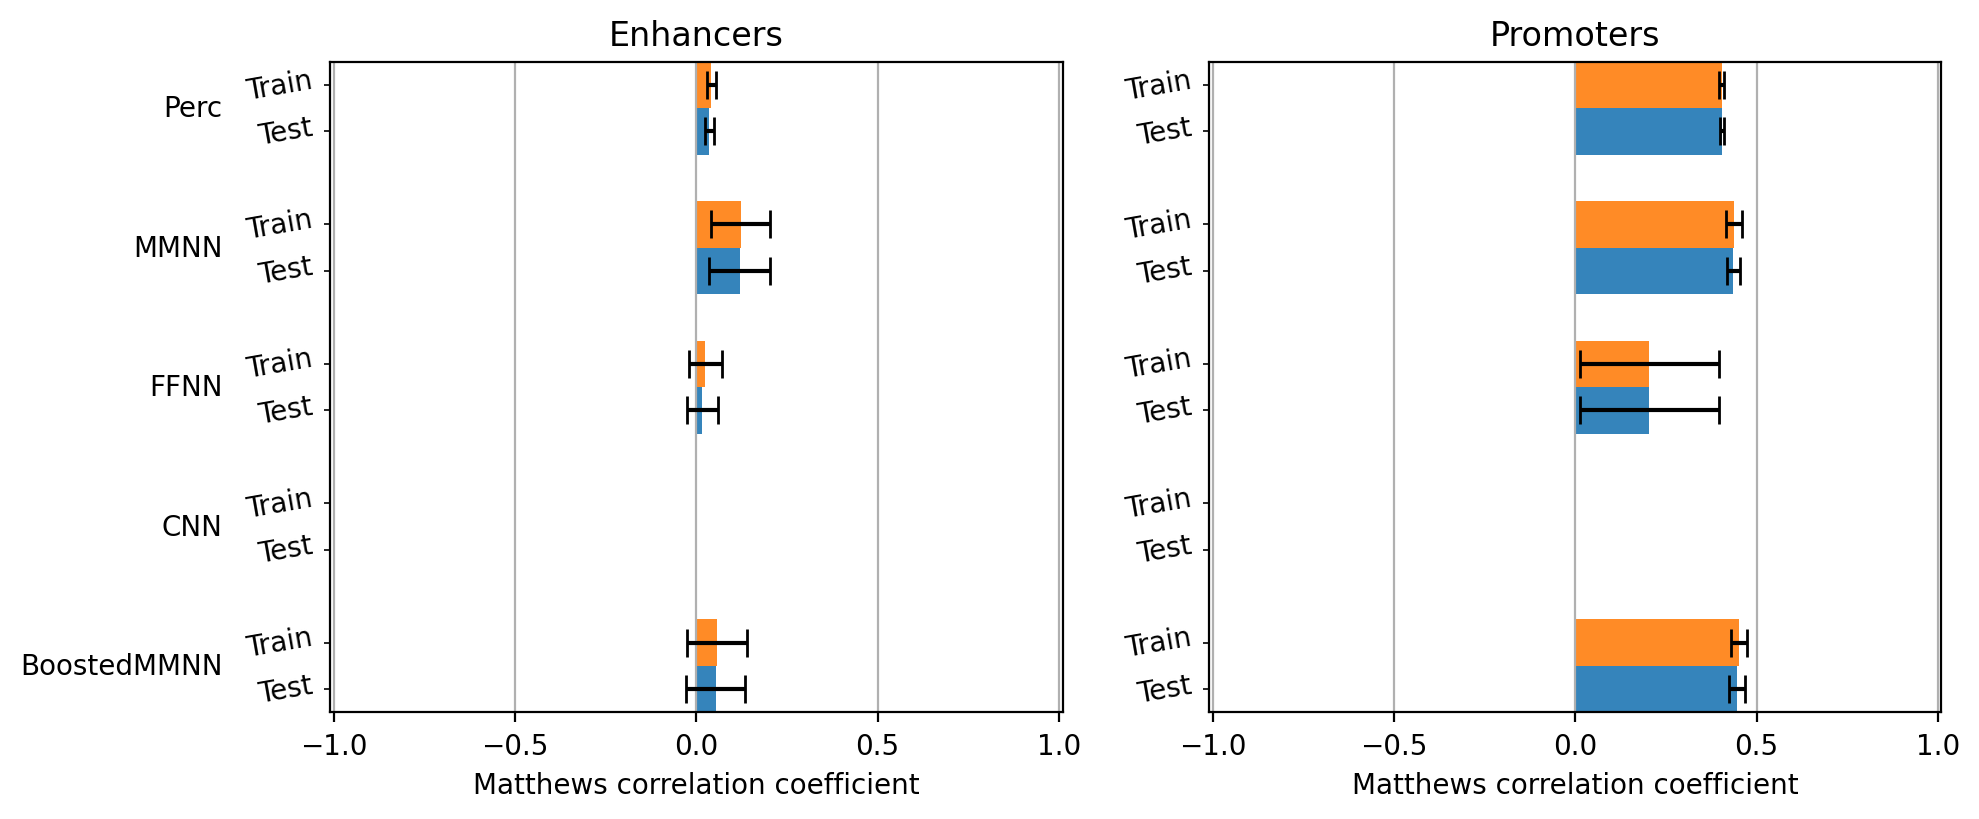

In [100]:
from barplots import barplots

barplots(
    all_binary_classification_performance.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=5,
    subplots=True,
    minor_rotation=10,
    show_legend = False
)